# Prototype Pipeline

This notebook proposes an initial pipeline prototype based on the functions described so far.

In [1]:
import os
import re
import sys
import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import random
import seaborn as sns

# Libraries required for plotting field
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import animation
from IPython.display import HTML
from IPython import display


# Custom libraries
sys.path.append('../')
from src.utils.feature_extraction import extract_play_outcome_features, extract_formation_features, extract_foul_features, extract_injury_features, extract_game_features
from definitions.fouls_def import ignore_fouls
from src.utils.viz_functions import drawPitch, drawPocket, animatePlay_Generic, animateScores
from src.utils.play_preprocessing import extractPlay, preprocessPlay_refBallInit, preprocessPlay_refQB, preprocessPlay_refQB_NFrames
from src.utils.player_influence import extract_play_players_influence, gaussian_player_influence_score
from src.utils.field_price_functions import calculate_field_price, gaussian_field_price
from src.utils.calculate_score import calculate_score

In [2]:
# Define input parameters
input_path = '../input'
preprocessing_path = '../processing'

config = {
    'hold_QB_ref': 20,
    'post_snap_time': 8,
    'pocket_len': 30.0,
    'pocket_res': 0.1,
    'pocket_linear_max_value': 1.0,
    'pocket_gaus_mu': 0.0,
    'pocket_gaus_sigma': 5.0,
    'gaus_mu': 0.0,
    'gaus_sigma': 2.0,
    'field_price_funct': gaussian_field_price,
    'player_infl_funct': gaussian_player_influence_score
}

In [3]:
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))
week1_data.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


# 1. Single Play Processing
Processing a single play can be done as follows:

In [20]:
# Define Game & Play ID
gameId = "2021090900"
playId = "97"

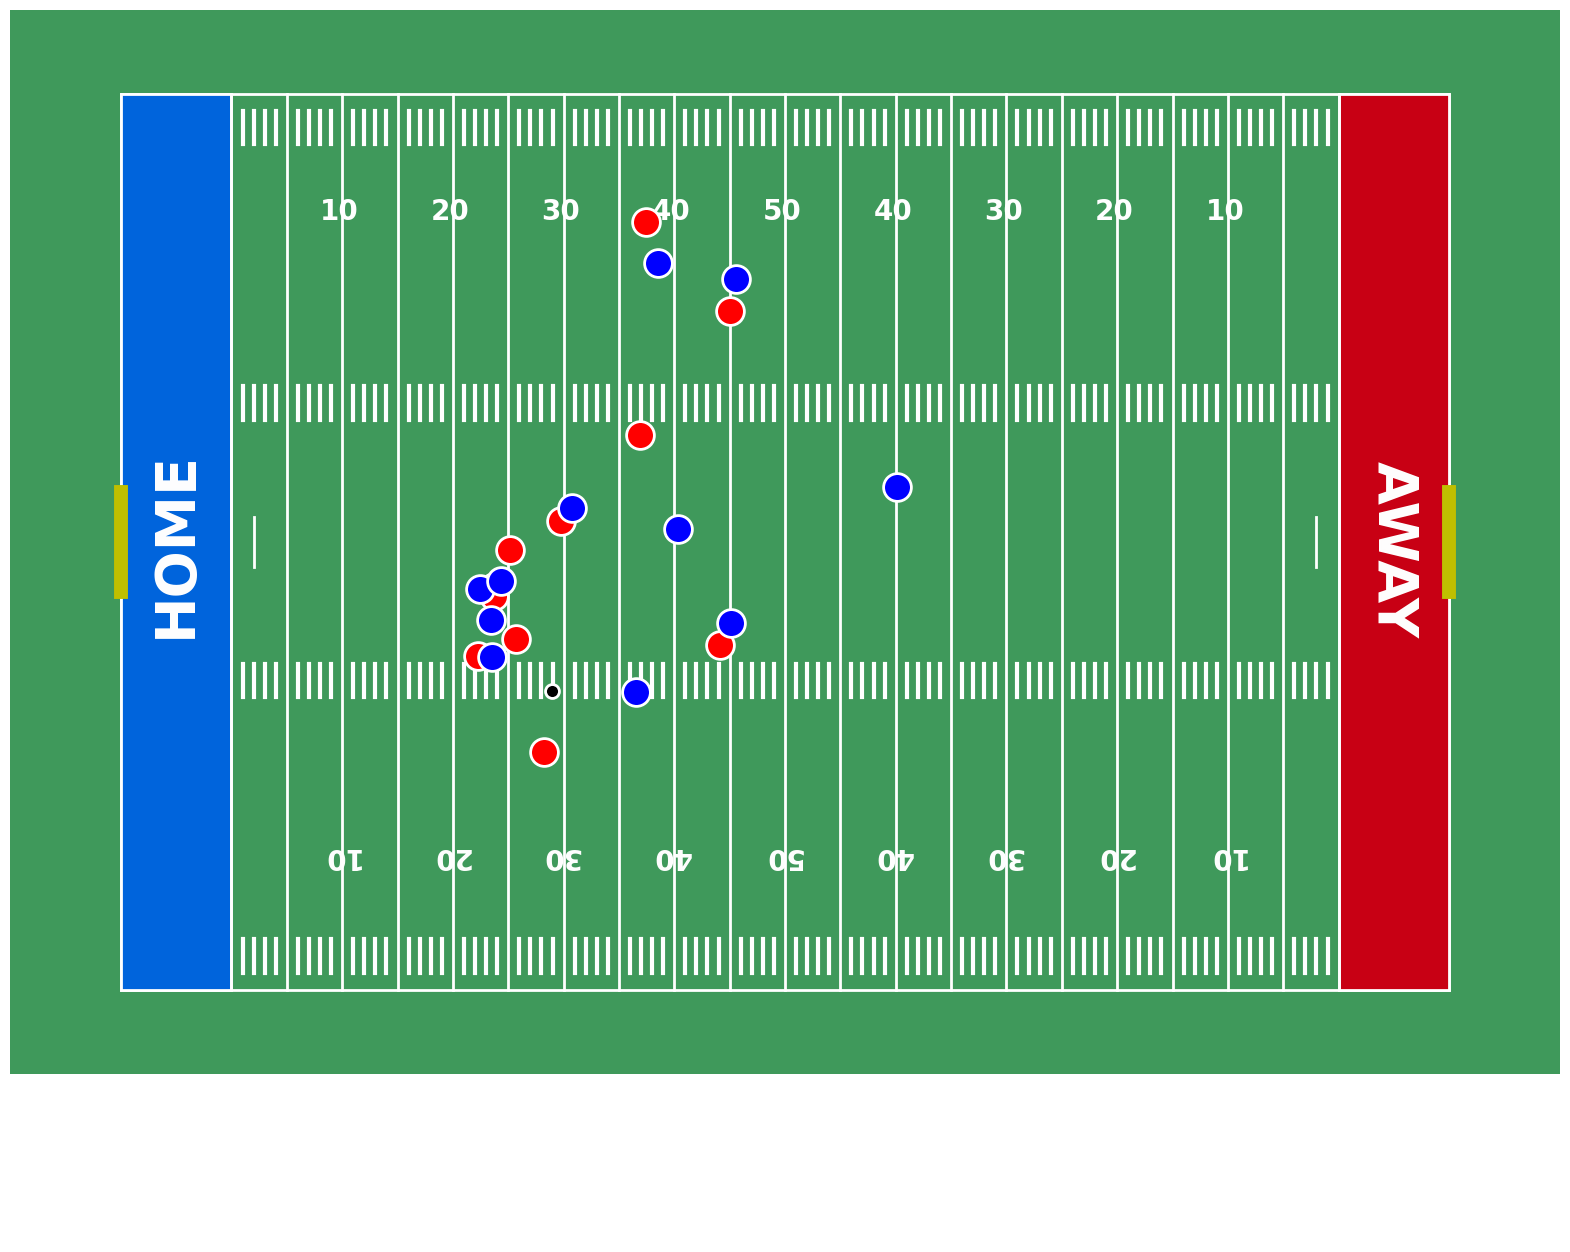

In [21]:
# Full Pitch Evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)

# Plot the play
animatePlay_Generic(team1, team2, ball, drawPitch(), store_path=f"../videos/{gameId}_{playId}_fullPitch.mp4")

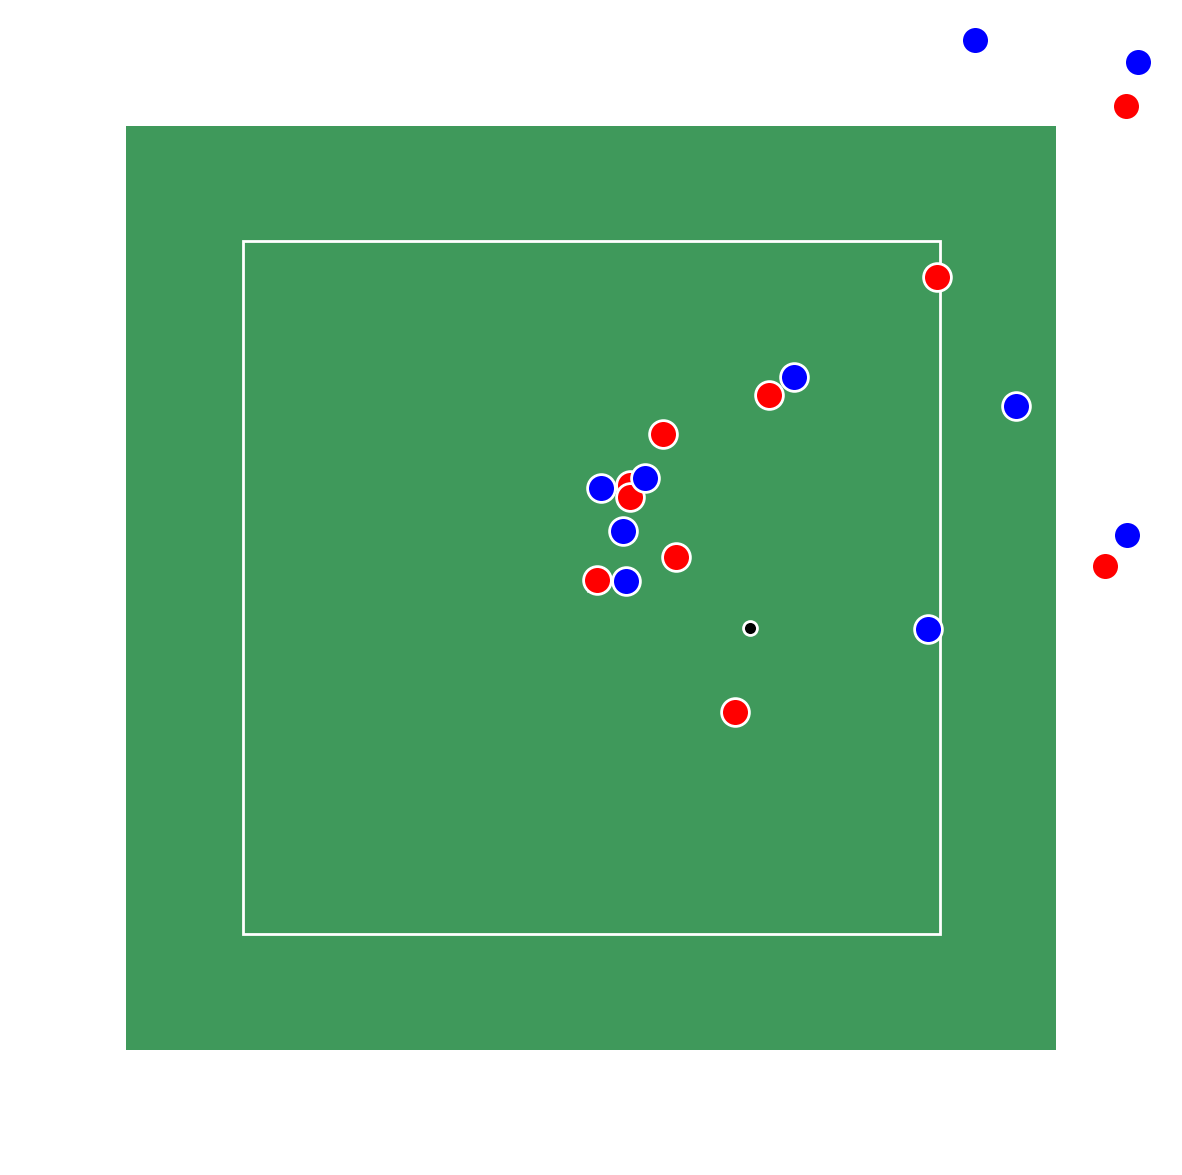

In [22]:
# Pocket Evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)
team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'], post_snap_time=config['post_snap_time'])

# Plot the play
animatePlay_Generic(team1, team2, ball, drawPocket(), store_path=f"../videos/{gameId}_{playId}_pocket.mp4")

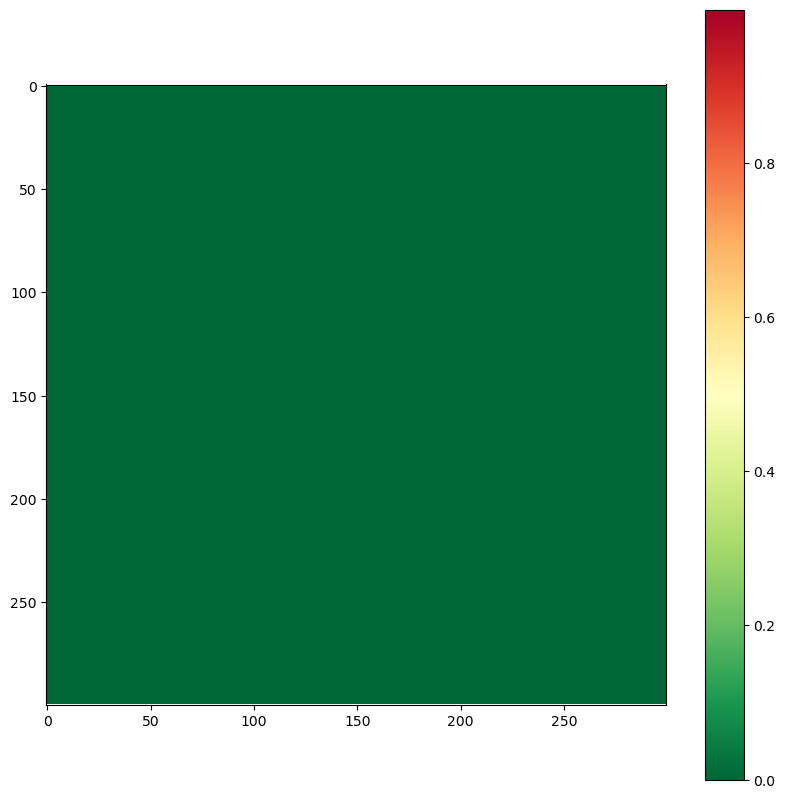

In [23]:
# Score evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)
team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'])

# Calculate players influence
scores = extract_play_players_influence(
    team_def=team2,
    infl_funct=config['player_infl_funct'],
    config=config
)

# Plot the play
animateScores(scores, store_path=f"../videos/{gameId}_{playId}_scores.mp4")

## Corner Case - Two or more QB in place
If two or more QB are playing at one specific moment, we need to determine which of them is going to play the ball. Additional code is included to determine this, like in the play (2021091211, 76)

In [9]:
# Define Game & Play ID
gameId = "2021091211"
playId = "76"

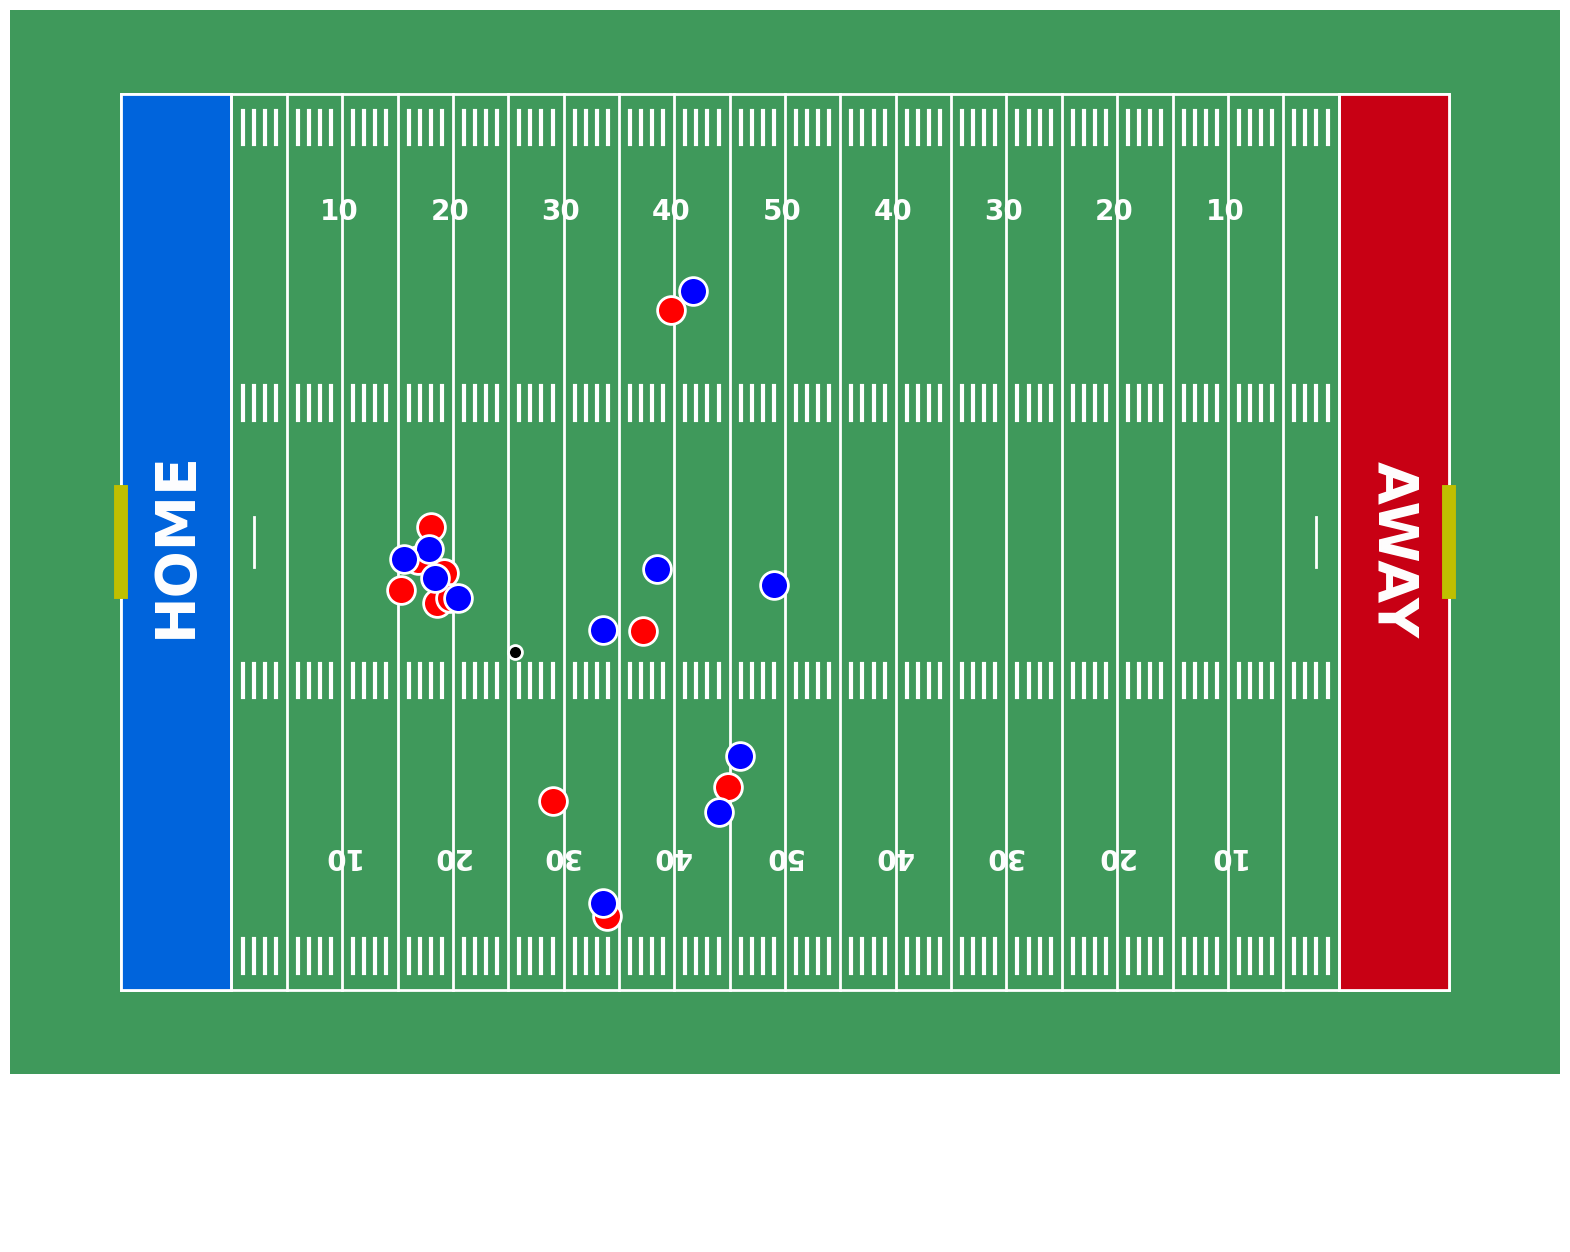

In [10]:
# Full Pitch Evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)

# Plot the play
animatePlay_Generic(team1, team2, ball, drawPitch(), store_path=f"../videos/{gameId}_{playId}_fullPitch.mp4")

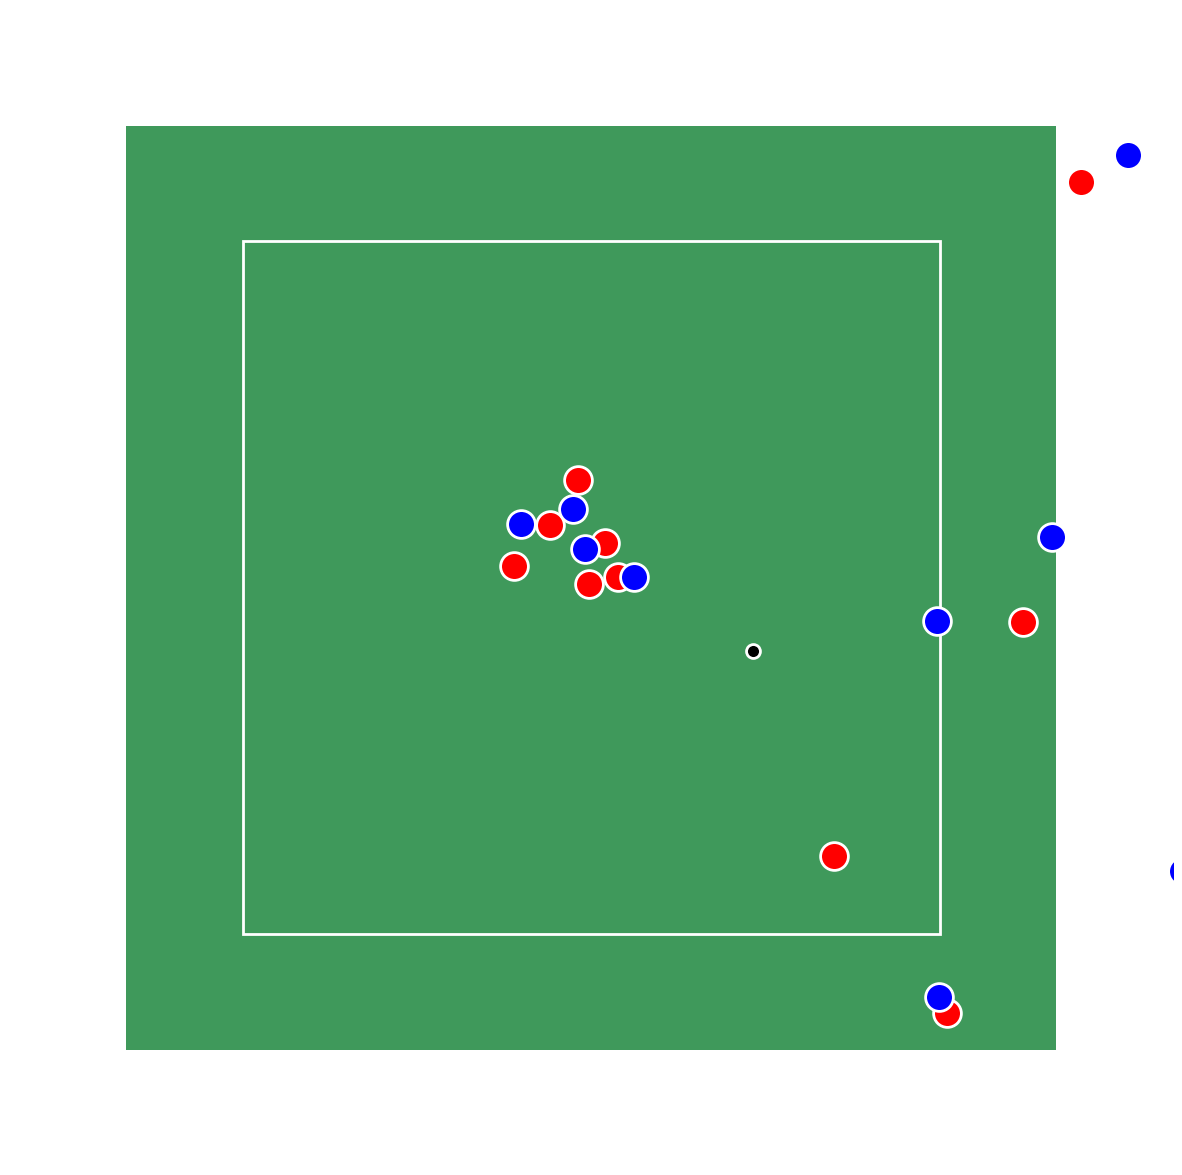

In [11]:
# Pocket Evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)
team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'], post_snap_time=config['post_snap_time'])

# Plot the play
animatePlay_Generic(team1, team2, ball, drawPocket(), store_path=f"../videos/{gameId}_{playId}_pocket.mp4")

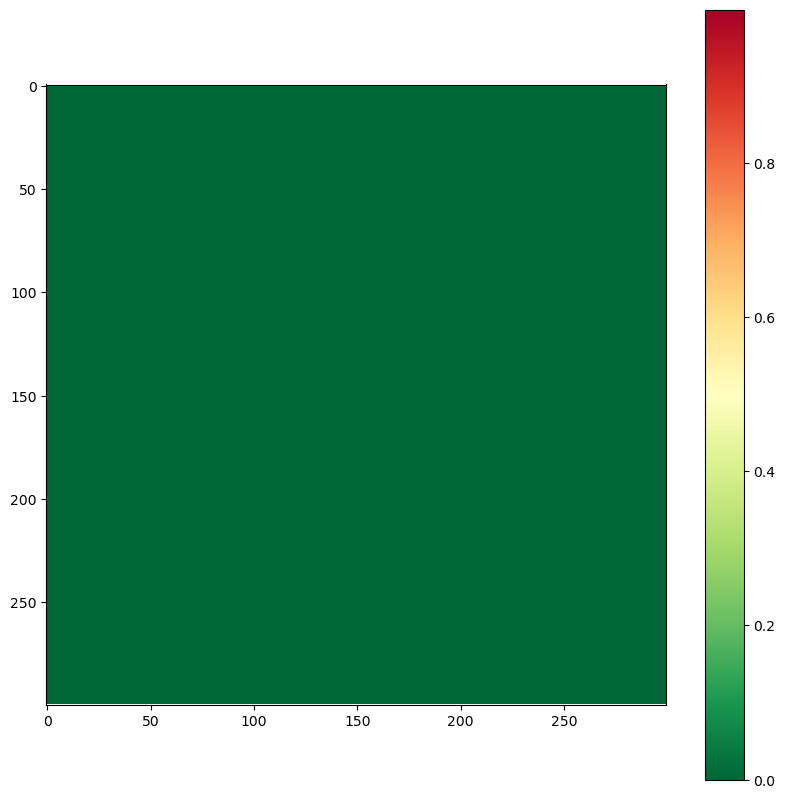

In [24]:
# Score evaluation
# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)
team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'])

# Calculate players influence
scores = extract_play_players_influence(
    team_def=team2,
    infl_funct=config['player_infl_funct'],
    config=config
)

# Plot the play
animateScores(scores, store_path=f"../videos/{gameId}_{playId}_scores.mp4")

# 2. Bulk Processing

This pipeline will create intermediate tables with information regarding the plays

## Step 1 - Features Extraction

In [9]:
# Load information regarding plays
plays_data = pd.read_csv(os.path.join(input_path, 'plays.csv'))
# Load information regarding games
games_data = pd.read_csv(os.path.join(input_path, 'games_enhanced.csv'))

# Perform all feature extractions - Plays Features
plays_outcomes = extract_play_outcome_features(plays_data).set_index(['gameId', 'playId'])
plays_formation = extract_formation_features(plays_data).set_index(['gameId', 'playId'])
plays_fouls = extract_foul_features(plays_data).set_index(['gameId', 'playId'])
plays_injury = extract_injury_features(plays_data).set_index(['gameId', 'playId'])

# Merge all these tables into one single big table
play_features = pd.concat([plays_outcomes, plays_formation, plays_fouls, plays_injury], axis=1)
play_features.head(5)

pass_complete  has_pocket_hold  was_qb_sacked  \
gameId     playId                                                  
2021090900 97              False             True          False   
           137              True             True          False   
           187              True             True          False   
           282             False             True          False   
           349             False             True          False   

                   achieved_pos_yards  gained_yards  touchdown  num_rb  \
gameId     playId                                                        
2021090900 97                   False             0      False       1   
           137                   True            28      False       1   
           187                   True             5      False       0   
           282                  False             0      False       1   
           349                  False             0      False       1   

                   num_wr  num_te  num_ol  ... num_off_foul  off_penalties  \
gameId     playId                          ...                               
2021090900 97           3       1       0  ...            0             []   
           137          2       2       0  ...            0             []   
           187          3       2       0  ...            0             []   
           282          2       2       0  ...            0             []   
           349          3       1       0  ...            0             []   

                  off_penalties_players num_def_foul  def_penalties  \
gameId     playId                                                     
2021090900 97                        []            0             []   
           137                       []            0             []   
           187                       []            0             []   
           282                       []            0             []   
           349                       []            0             []   

                  def_penalties_players num_off_injuries  off_players_injured  \
gameId     playId                                                               
2021090900 97                        []                0                   []   
           137                       []                0                   []   
           187                       []                0                   []   
           282                       []                0                   []   
           349                       []                0                   []   

                  num_def_injuries  def_players_injured  
gameId     playId                                        
2021090900 97                    0                   []  
           137                   0                   []  
           187                   0                   []  
           282                   0                   []  
           349                   0                   []  

[5 rows x 21 columns]

In [10]:
# Load information regarding games
games_data = pd.read_csv(os.path.join(input_path, 'games_enhanced.csv'))

# Performing all feature extractions - Game Features
games_features = extract_game_features(games_data)
games_features

,team,gameScore,hasWon
gameId,,,
2021090900,TB,31,True
2021090900,DAL,29,False
2021091200,ATL,6,False
2021091200,PHI,32,True
2021091201,BUF,16,False
...,...,...,...
2021103111,TB,27,False
2021103112,MIN,16,False
2021103112,DAL,20,True


In [11]:
# Store all features - Play and Games
play_features.to_csv(f"{preprocessing_path}/play_features.csv")
games_features.to_csv(f"{preprocessing_path}/games_features.csv")

## Step 2 - Extract scores for all plays

In [12]:
# Define number of weeks to analyize
num_weeks = 8

# Generate files names
week_files = []
for i in range(num_weeks):
    week_files.append(f'week{i+1}.csv')

In [ ]:
# For all weeks, extract scores
all_scores_info = []
for week_file in week_files:

    print(f"- Analyzing {week_file}")

    # Load information for an entire week
    week_data = pd.read_csv(os.path.join(input_path, week_file))

    # Extract information about the associated games and plays
    unique_ids = week_data[['gameId', 'playId']].drop_duplicates().values

    for gameId, playId in tqdm.tqdm(unique_ids):

        # Extract info from the play
        team1, team2, ball = extractPlay(week_data, gameId, playId)
        team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'])

        ############################################################
        # Extract player influence
        players_influence = extract_play_players_influence(team2, infl_funct=config['player_infl_funct'], config=config)

        # Extract field price
        field_price = calculate_field_price(price_funct=config['field_price_funct'], config=config)

        # Calculate scores
        pocketScore = calculate_score(players_influence, field_price)
        ############################################################
        # For now, we will include random values
        # pocketScore = random.uniform(0, 1)
        ############################################################

        all_scores_info.append({
            'gameId': gameId,
            'playId': playId,
            'offTeam': team1.team.drop_duplicates().values[0],
            'pocketScore': pocketScore 
        })


In [ ]:
scores = pd.DataFrame(all_scores_info).set_index(['gameId', 'playId'])
play_scores_and_features =  pd.concat([scores, plays_outcomes, plays_formation, plays_fouls, plays_injury], axis=1)
play_scores_and_features.head(5)


offTeam  pocketScore  pass_complete  has_pocket_hold  \
gameId     playId                                                        
2021090900 97          TB     0.144388          False             True   
           137        DAL     0.403825           True             True   
           187        DAL     0.738150           True             True   
           282        DAL     0.499961          False             True   
           349        DAL     0.831946          False             True   

                   was_qb_sacked  achieved_pos_yards  gained_yards  touchdown  \
gameId     playId                                                               
2021090900 97              False               False             0      False   
           137             False                True            28      False   
           187             False                True             5      False   
           282             False               False             0      False   
           349             False               False             0      False   

                   num_rb  num_wr  ...  num_off_foul  off_penalties  \
gameId     playId                  ...                                
2021090900 97           1       3  ...             0             []   
           137          1       2  ...             0             []   
           187          0       3  ...             0             []   
           282          1       2  ...             0             []   
           349          1       3  ...             0             []   

                  off_penalties_players  num_def_foul def_penalties  \
gameId     playId                                                     
2021090900 97                        []             0            []   
           137                       []             0            []   
           187                       []             0            []   
           282                       []             0            []   
           349                       []             0            []   

                  def_penalties_players  num_off_injuries off_players_injured  \
gameId     playId                                                               
2021090900 97                        []                 0                  []   
           137                       []                 0                  []   
           187                       []                 0                  []   
           282                       []                 0                  []   
           349                       []                 0                  []   

                  num_def_injuries  def_players_injured  
gameId     playId                                        
2021090900 97                    0                   []  
           137                   0                   []  
           187                   0                   []  
           282                   0                   []  
           349                   0                   []  

[5 rows x 23 columns]

In [ ]:
play_scores_and_features.to_csv(f"{preprocessing_path}/play_scores_and_features.csv")

# Step 3 - Score Analysis based on features

This last step would be to evaluate the score correlation with the different extracted features. This can be done in different aggregation levels:
- Single play
- Full game
- Full Season

## 3.1 - Single Play Analysis

In [13]:
def evaluate_singleplay_scores(scores_file):

    # Load information based on the analysis provided
    analysis_results = pd.read_csv(scores_file)
    
    #################################################################
    # Run a set of analysis to explore the correlation between the score and the extracted features
    #################################################################
    # Play Outcome Analysis
    # Figure height and width
    width = 40
    height = 10
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 4
    # Analysis 1 - Score vs Gained Yards
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='gained_yards')
    plt.xlabel("Gained yards")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Gained Yards")
    # Analysis 2 - Score vs Pass complete
    plt.subplot(rows,cols,2)
    sns.violinplot(data=analysis_results, y='pocketScore', x='pass_complete')
    plt.xlabel("Was it a complete pass?")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Complete pass")
    # Analysis 3 - Score vs Pocket hold
    plt.subplot(rows,cols,3)
    sns.violinplot(data=analysis_results, y='pocketScore', x='has_pocket_hold')
    plt.xlabel("Had pocket hold?")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Pocket hold")
    # Analysis 4 - Score vs Pocket hold
    plt.subplot(rows,cols,4)
    sns.violinplot(data=analysis_results, y='pocketScore', x='was_qb_sacked')
    plt.xlabel("Was QB sacked?")
    plt.ylabel("Pocket Score")
    plt.title("Score vs QB Sacked")
    
    #################################################################
    # Formation analysis
    # Figure height and width
    height = 10
    width = 40
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 4
    # Analysis 1 - Score vs # RB
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_rb')
    plt.xlabel("Number of RB")
    plt.ylabel("Pocket Score")
    plt.title("Score vs # RB")
    # Analysis 2 - Score vs # WR
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_wr')
    plt.xlabel("Number of WR")
    plt.ylabel("Pocket Score")
    plt.title("Score vs # WR")
    # Analysis 3 - Score vs # TE
    plt.subplot(rows,cols,3)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_te')
    plt.xlabel("Number of TE")
    plt.ylabel("Pocket Score")
    plt.title("Score vs # TE")
    # Analysis 4 - Score vs # OL
    plt.subplot(rows,cols,4)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_ol')
    plt.xlabel("Number of OL")
    plt.ylabel("Pocket Score")
    plt.title("Score vs # OL")

    #################################################################
    # Foul analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Fouls
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_off_foul')
    plt.xlabel("Number of Offensive Fouls")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Off Fouls")
    # Analysis 2 - Score vs Num Defensive Fouls
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_def_foul')
    plt.xlabel("Number of Defensive Fouls")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Def Fouls")
    
    #################################################################
    # Injury analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Injuries
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_off_injuries')
    plt.xlabel("Number of Offensive Injuries")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Off Injuries")
    # Analysis 2 - Score vs Num Defensive Injuries
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='pocketScore', x='num_def_injuries')
    plt.xlabel("Number of Defensive Injuries")
    plt.ylabel("Pocket Score")
    plt.title("Score vs Def Injuries")

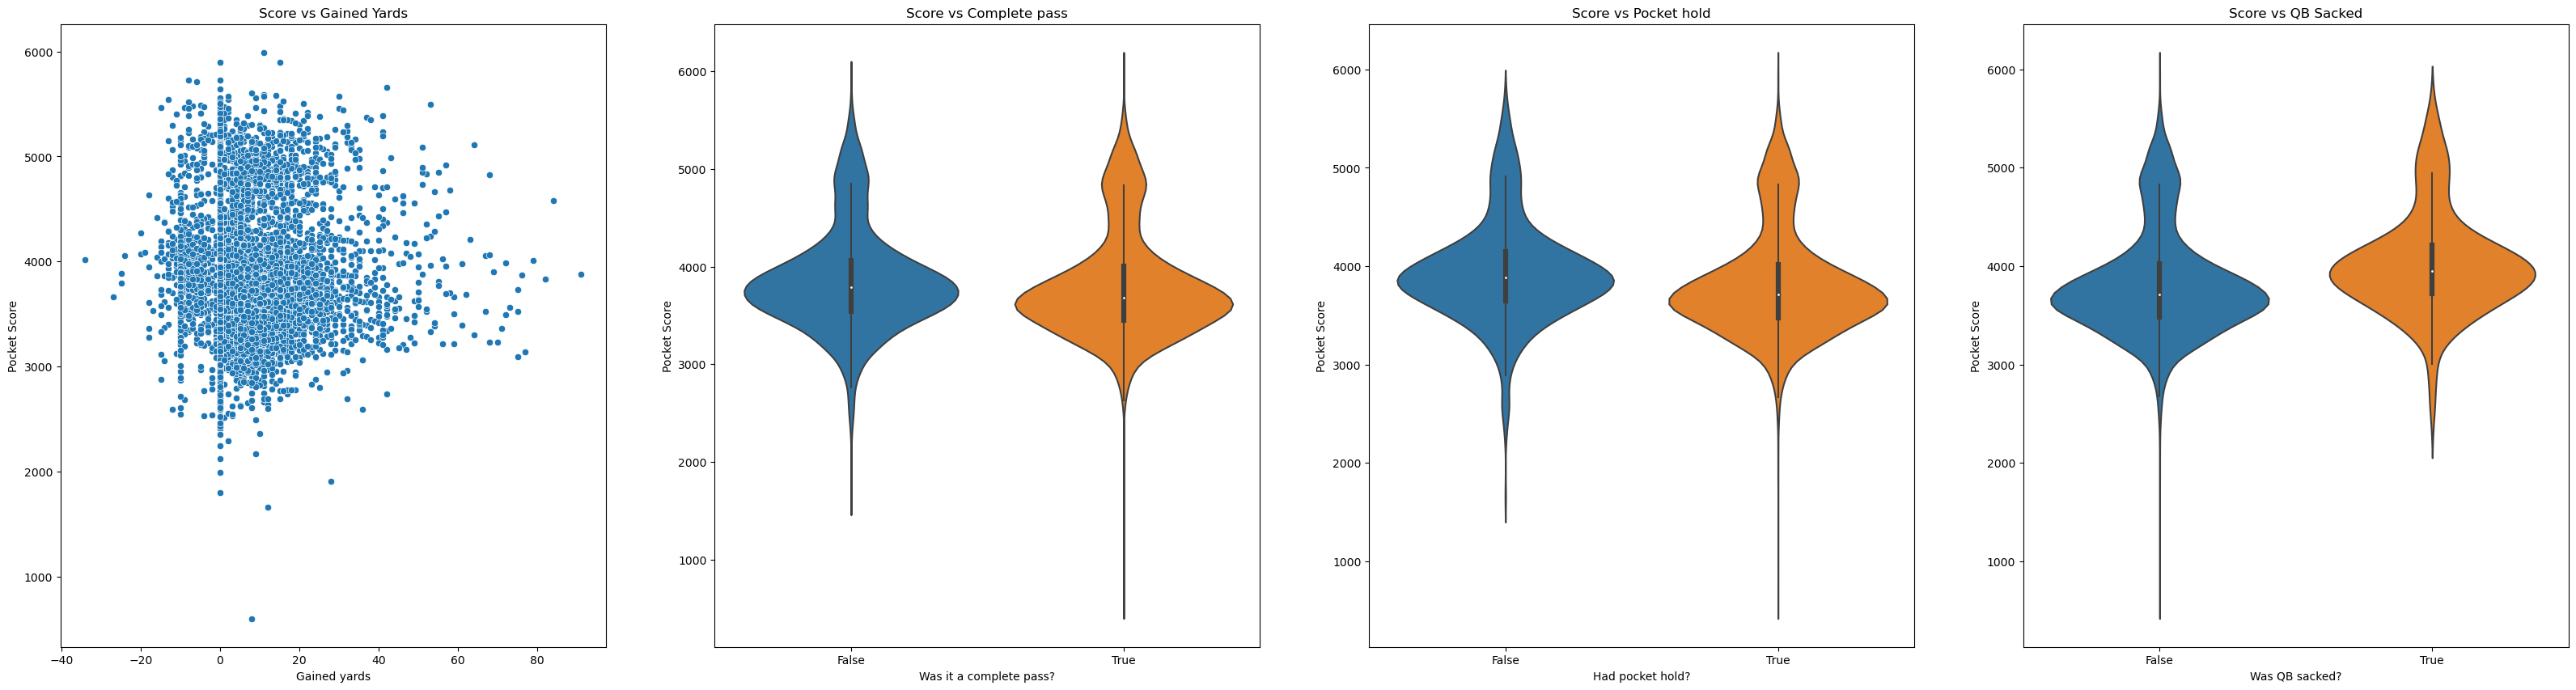

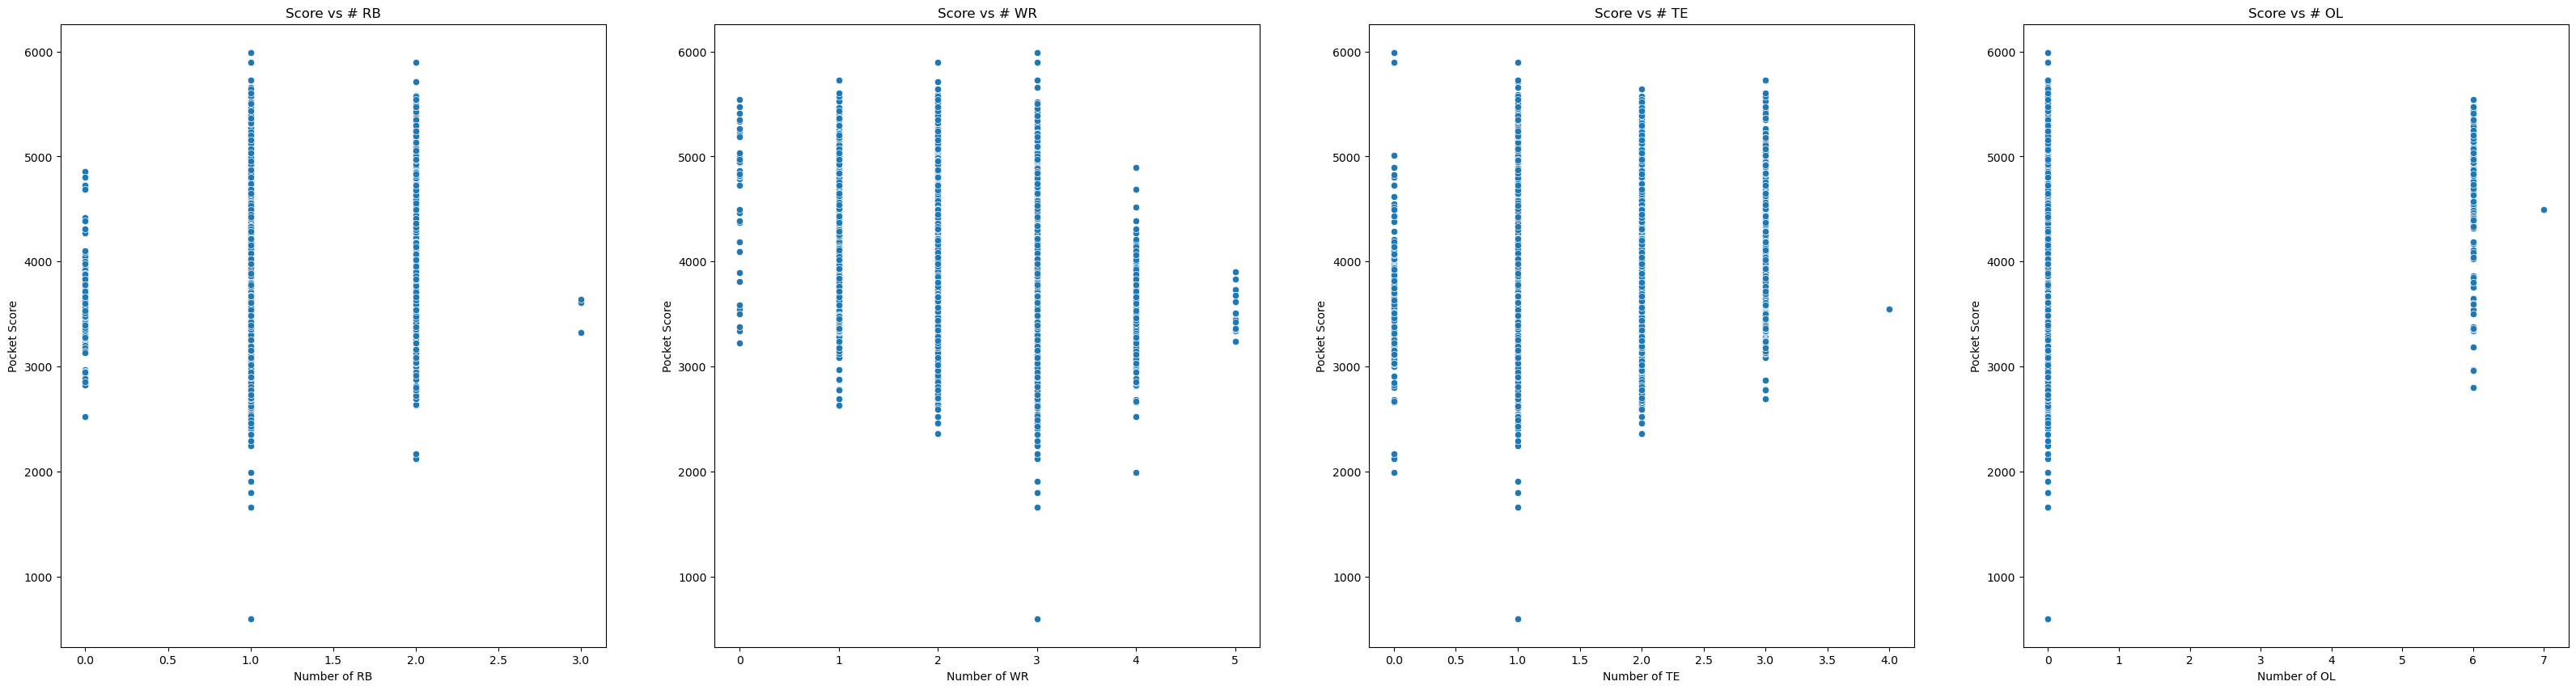

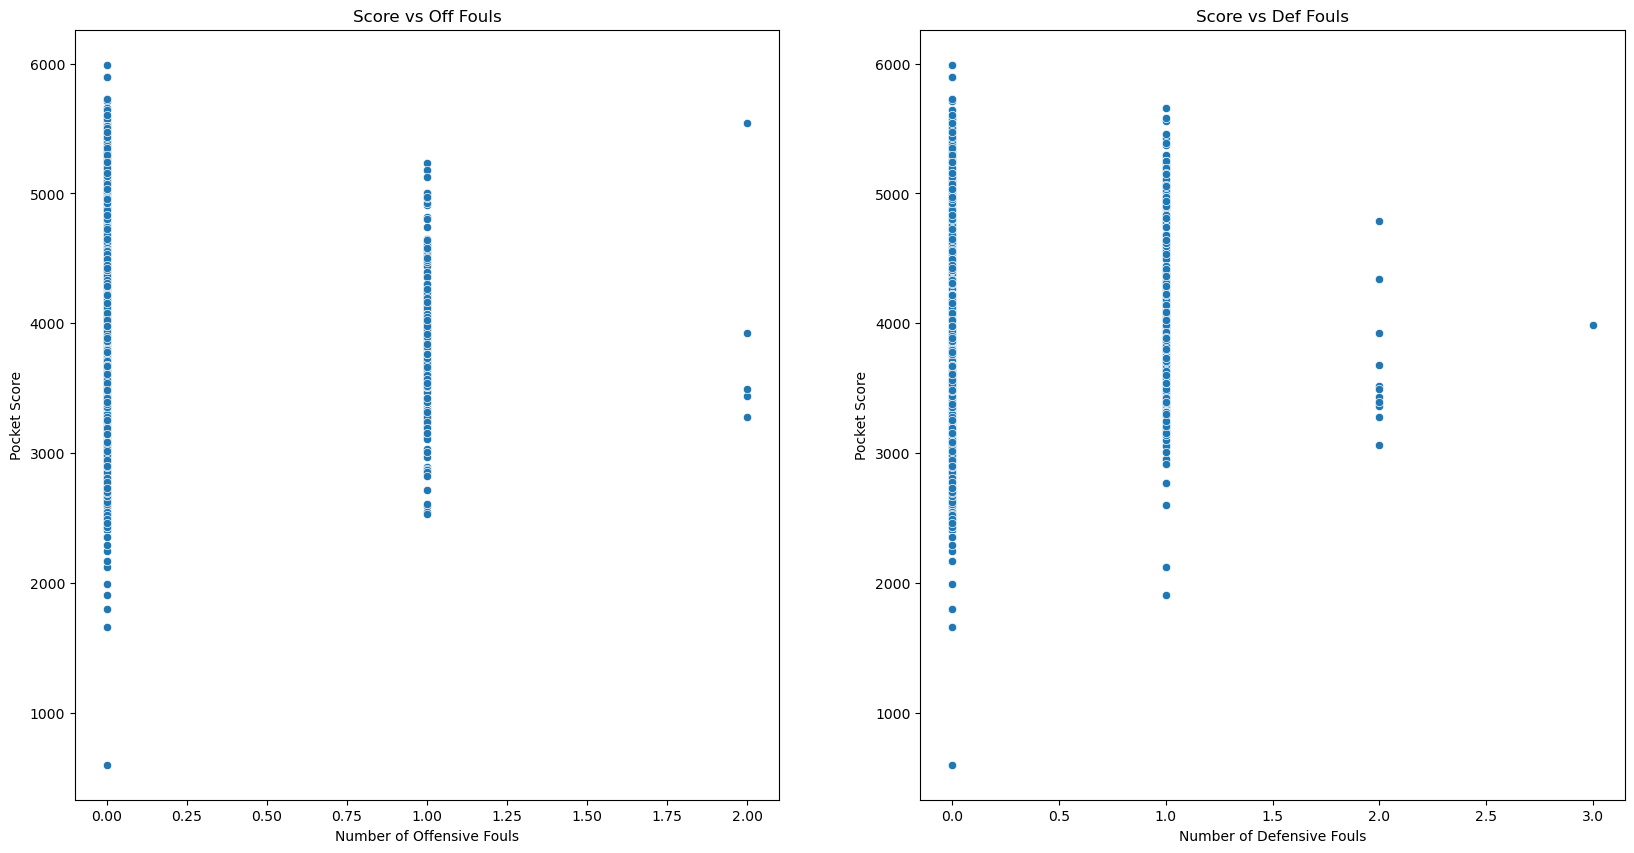

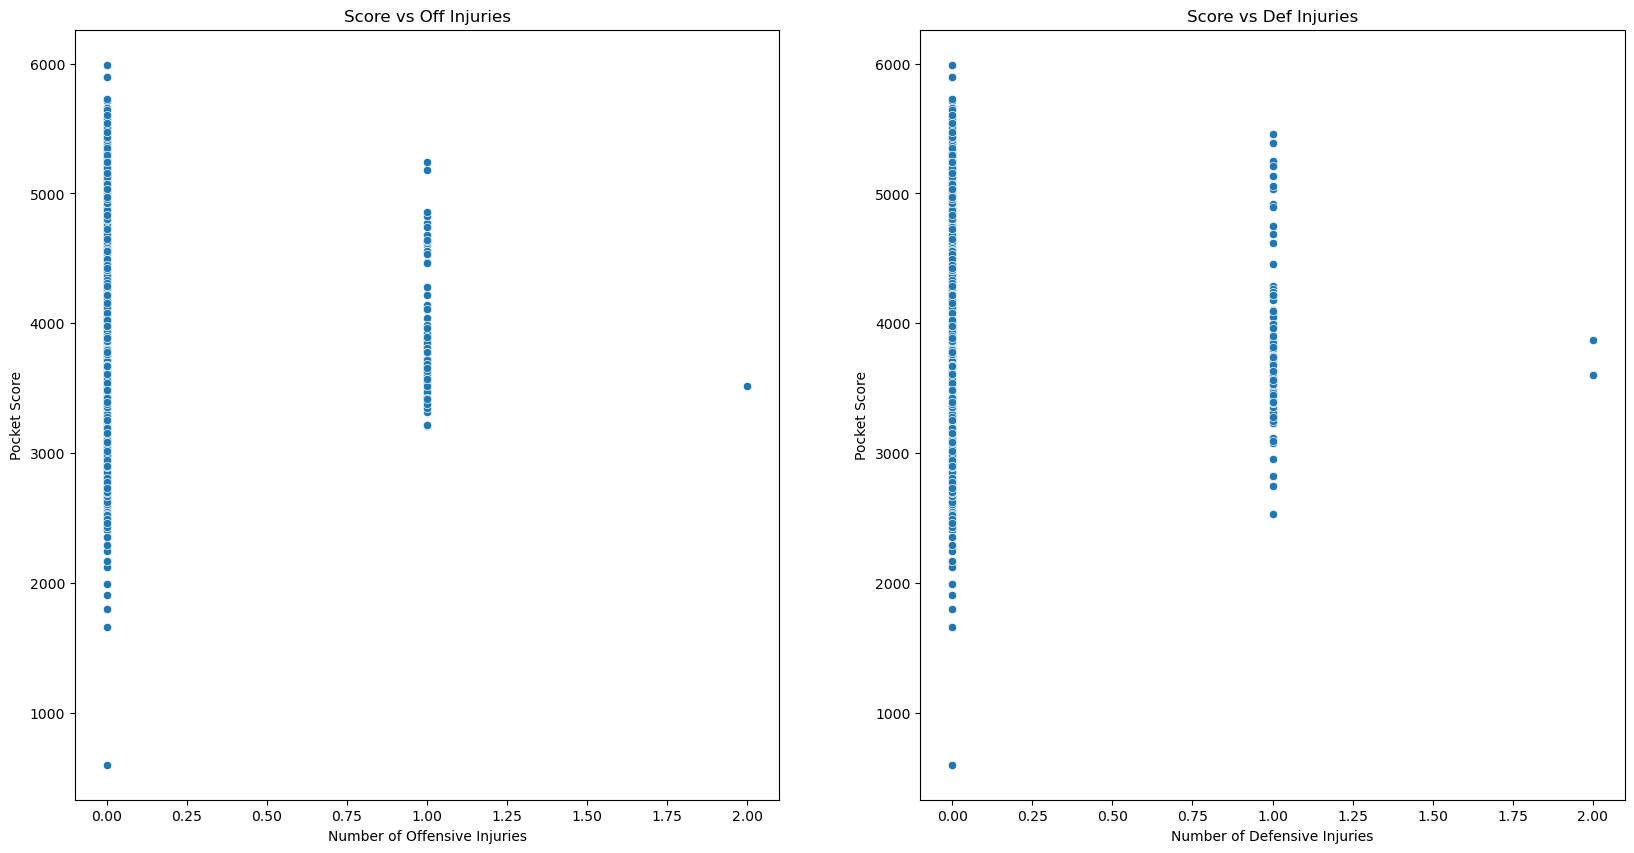

In [14]:
evaluate_singleplay_scores(f"{preprocessing_path}/play_scores_and_features.csv")

## 3.2 - Full Match Analysis
In this analysis, a set of aggregations are performed to compare teams based on single matches.

In [4]:
def process_team_perf_match(records, games_results):

    # Remove extract values
    gameId = records.gameId.values[0]
    offTeam = records.offTeam.values[0]

    # Extract games result for this specific game
    game_result = games_results.loc[(games_results.gameId == gameId) & (games_results.team == offTeam)]

    # Create a set of features for each match
    team_match_perf = {
        'gameId': gameId,
        'offTeam': offTeam,
        'gameScore': game_result.gameScore,
        'wonGame': game_result.hasWon,
        'avgPocketScore': records.pocketScore.mean(),
        'cumGainedYards': records.gained_yards.sum(),
        'avgGainedYards': records.gained_yards.mean(),
        'numPassComplete': records.pass_complete.sum(),
        'percPassComplete': (records.pass_complete.sum() / len(records)) * 100.0,
        'numPocketHold': records.has_pocket_hold.sum(),
        'percPocketHold': (records.has_pocket_hold.sum() / len(records)) * 100.0,
        'numQBSacked': records.was_qb_sacked.sum(),
        'percQBSacked': (records.was_qb_sacked.sum() / len(records)) * 100.0,
        'numTouchdowns': records.touchdown.sum(),
        'numOffFouls': records.num_off_foul.sum(),
        'numDefFouls': records.num_def_foul.sum(),
        'numOffInjuries': records.num_off_injuries.sum(),
        'numDefInjuries': records.num_def_injuries.sum()
    }
    performance = pd.DataFrame(team_match_perf)
        
    return performance

def agg_scores_by_match(scores_file, game_features_file):
    
    # Load information based on the analysis provided
    analysis_results = pd.read_csv(scores_file)
    # Load the games information
    games_results = pd.read_csv(game_features_file)
    # Group all records by team and by match - This is not the right way of doing this
    match_performance_analysis = analysis_results.groupby(['gameId', 'offTeam']).apply(process_team_perf_match, games_results=games_results).reset_index(drop=True)
    # Return the analysis result  
    return match_performance_analysis

In [5]:
result = agg_scores_by_match(f"{preprocessing_path}/play_scores_and_features.csv", f"{preprocessing_path}/games_features.csv")
result.head(5)

,gameId,offTeam,gameScore,wonGame,avgPocketScore,cumGainedYards,avgGainedYards,numPassComplete,percPassComplete,numPocketHold,percPocketHold,numQBSacked,percQBSacked,numTouchdowns,numOffFouls,numDefFouls,numOffInjuries,numDefInjuries
0,2021090900,DAL,29,False,3858.527141,326,6.150943,33,62.264151,49,92.452830,1,1.886792,3,4,6,0,3
1,2021090900,TB,31,True,3647.144110,348,7.909091,27,61.363636,44,100.000000,0,0.000000,4,2,2,0,0
2,2021091200,ATL,6,False,4004.459289,117,2.659091,23,52.272727,40,90.909091,3,6.818182,0,4,2,1,0
3,2021091200,PHI,32,True,3632.167641,179,6.172414,18,62.068966,24,82.758621,1,3.448276,2,1,0,0,0
4,2021091201,BUF,16,False,3496.562617,213,3.872727,28,50.909091,50,90.909091,3,5.454545,1,5,2,0,0


In [6]:
result.to_csv(f"{preprocessing_path}/week_scores_and_features.csv", index=False)

In [7]:
def evaluate_match_scores(scores_file):

    # Load information based on the analysis provided
    analysis_results = pd.read_csv(scores_file)
    
    #################################################################
    # Run a set of analysis to explore the correlation between the score and the extracted features
    #################################################################
    # Play Outcome Analysis
    # Figure height and width
    width = 40
    height = 10
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 5
    # Analysis 1 - Score vs Cum Gained Yards
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='cumGainedYards')
    plt.xlabel("Cumulative Gained yards")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Cum Gained Yards")
    # Analysis 2 - Score vs Avg Gained Yards
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='avgGainedYards')
    plt.xlabel("Average Gained yards")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Avg Gained Yards")
    # Analysis 3 - Score vs Pass complete
    plt.subplot(rows,cols,3)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percPassComplete')
    plt.xlabel("Percentage Complete Passes")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs % Complete pass")
    # Analysis 4 - Score vs Pocket hold
    plt.subplot(rows,cols,4)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percPocketHold')
    plt.xlabel("Percentage Pocket hold")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs % Pocket hold")
    # Analysis 5 - Score vs Pocket hold
    plt.subplot(rows,cols,5)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percQBSacked')
    plt.xlabel("Percentage QB Sacked")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs % QB Sacked")

    #################################################################
    # Game Analysis
    # Figure height and width
    width = 20
    height = 10
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Gained Yards
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='gameScore')
    plt.xlabel("Game Score")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Game Score")
    # Analysis 2 - Score vs Pass complete
    plt.subplot(rows,cols,2)
    sns.violinplot(data=analysis_results, y='avgPocketScore', x='wonGame')
    plt.xlabel("Did the team won the game?")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Game Result")

    #################################################################
    # Foul analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Fouls
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numOffFouls')
    plt.xlabel("Number of Offensive Fouls")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Off Fouls")
    # Analysis 2 - Score vs Num Defensive Fouls
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numDefFouls')
    plt.xlabel("Number of Defensive Fouls")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Def Fouls")
    
    #################################################################
    # Injury analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Injuries
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numOffInjuries')
    plt.xlabel("Number of Offensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Off Injuries")
    # Analysis 2 - Score vs Num Defensive Injuries
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numDefInjuries')
    plt.xlabel("Number of Defensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Def Injuries")

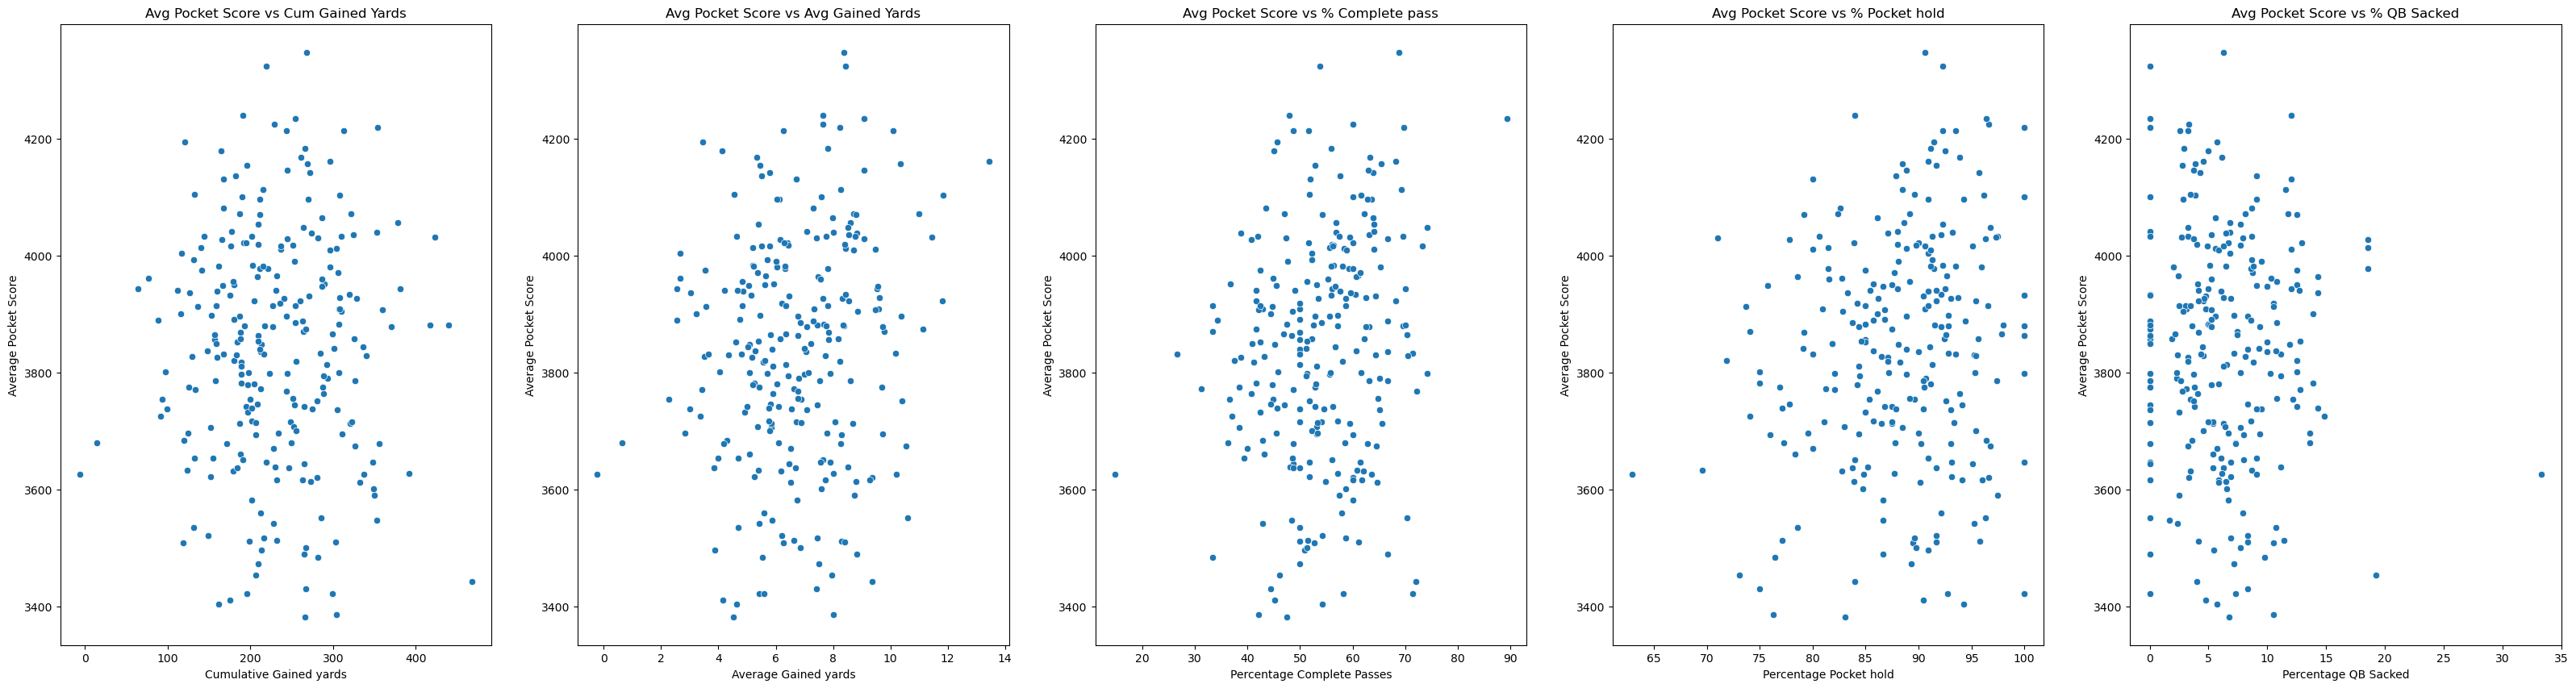

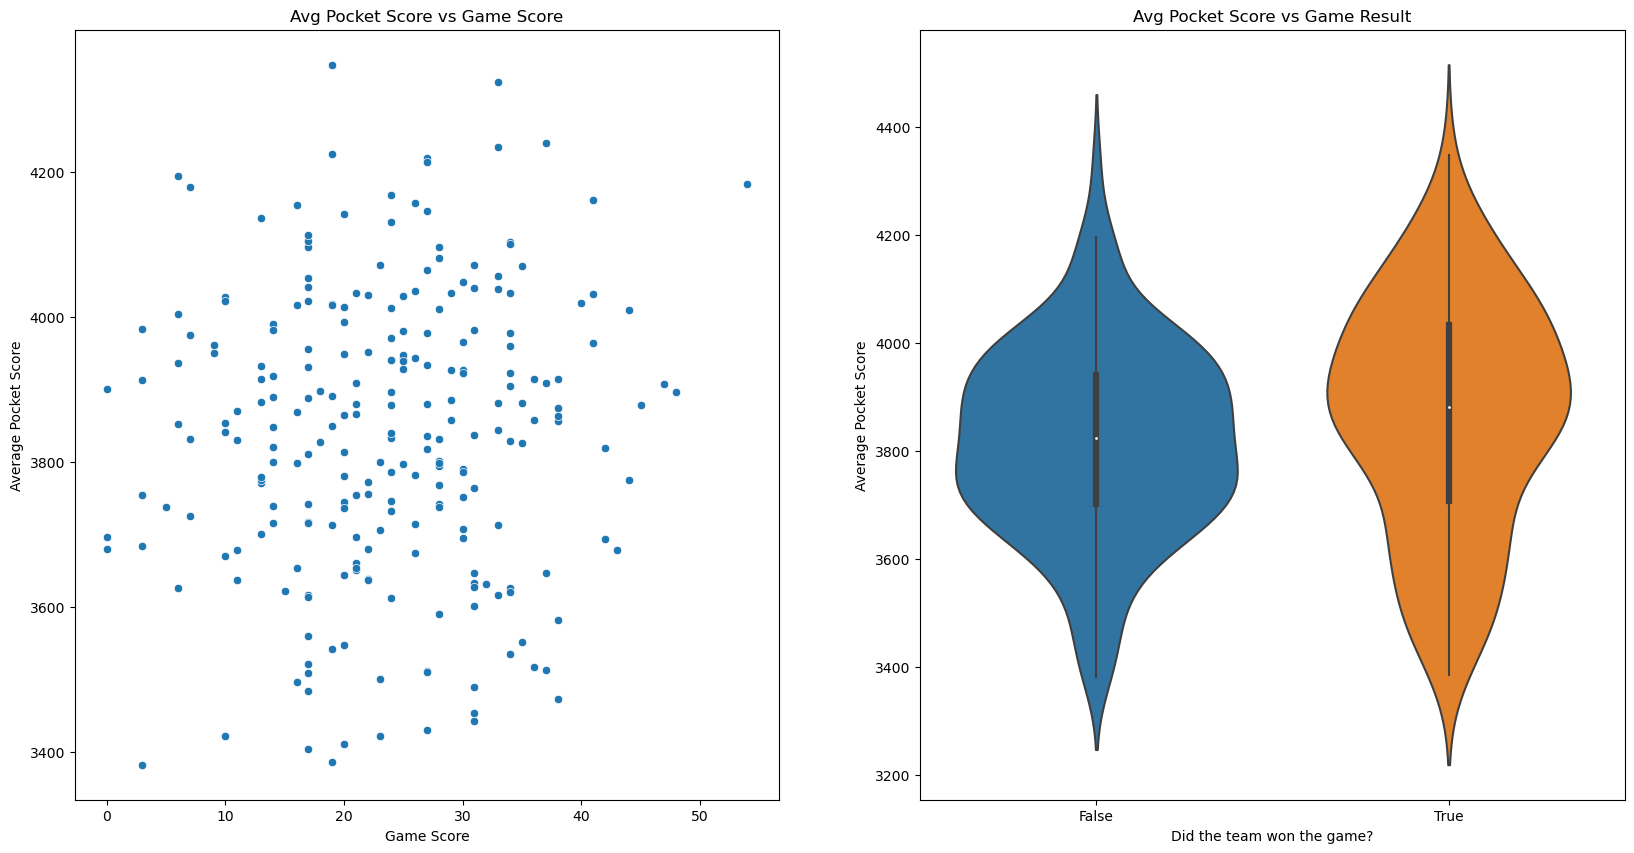

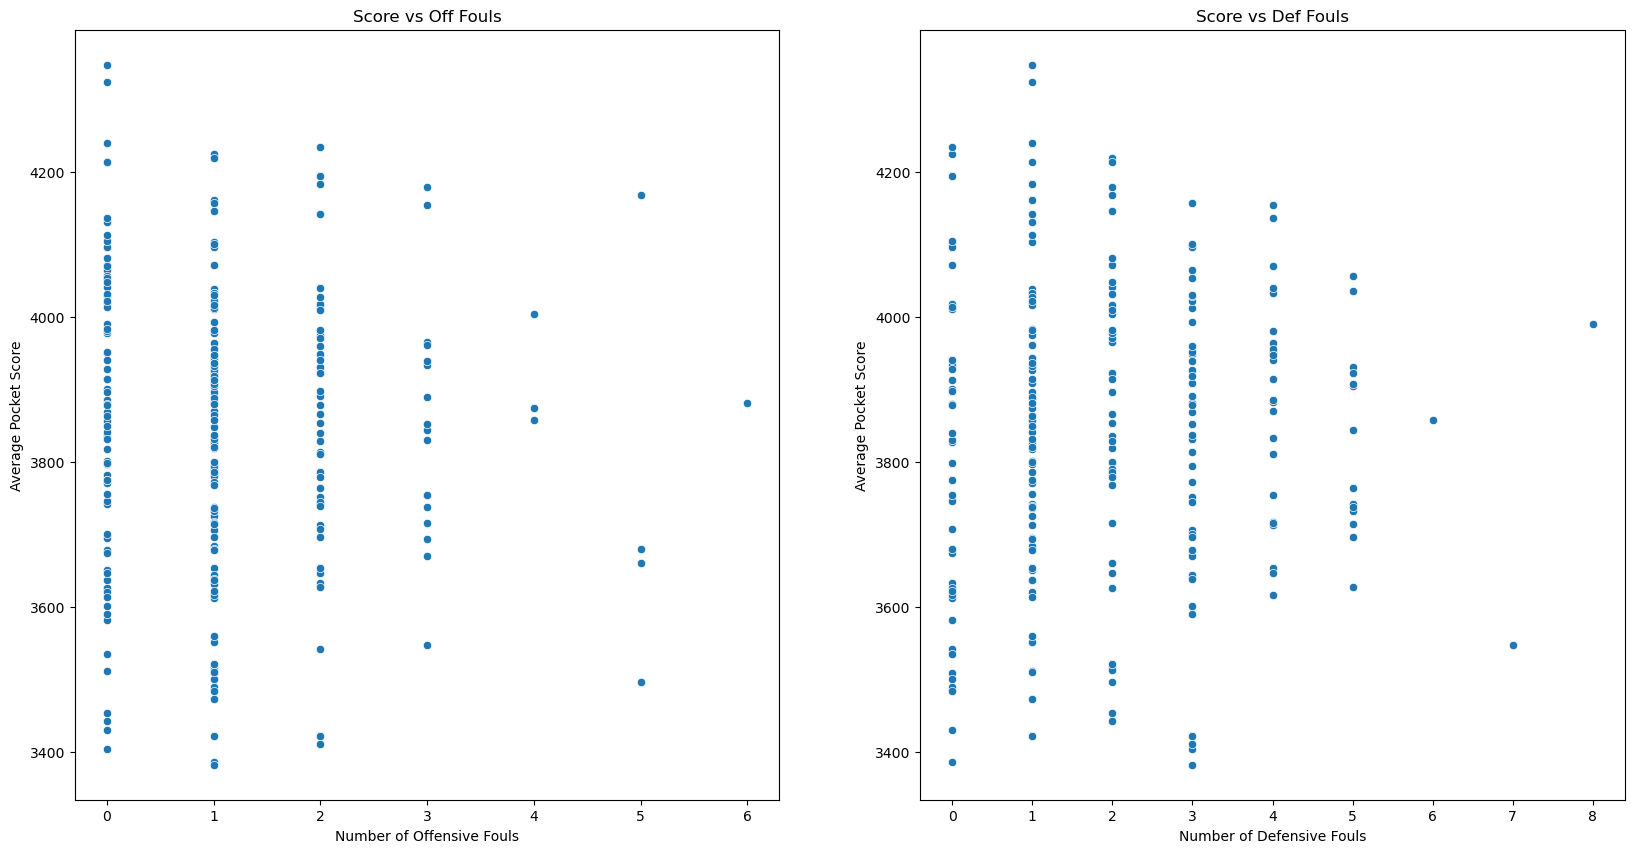

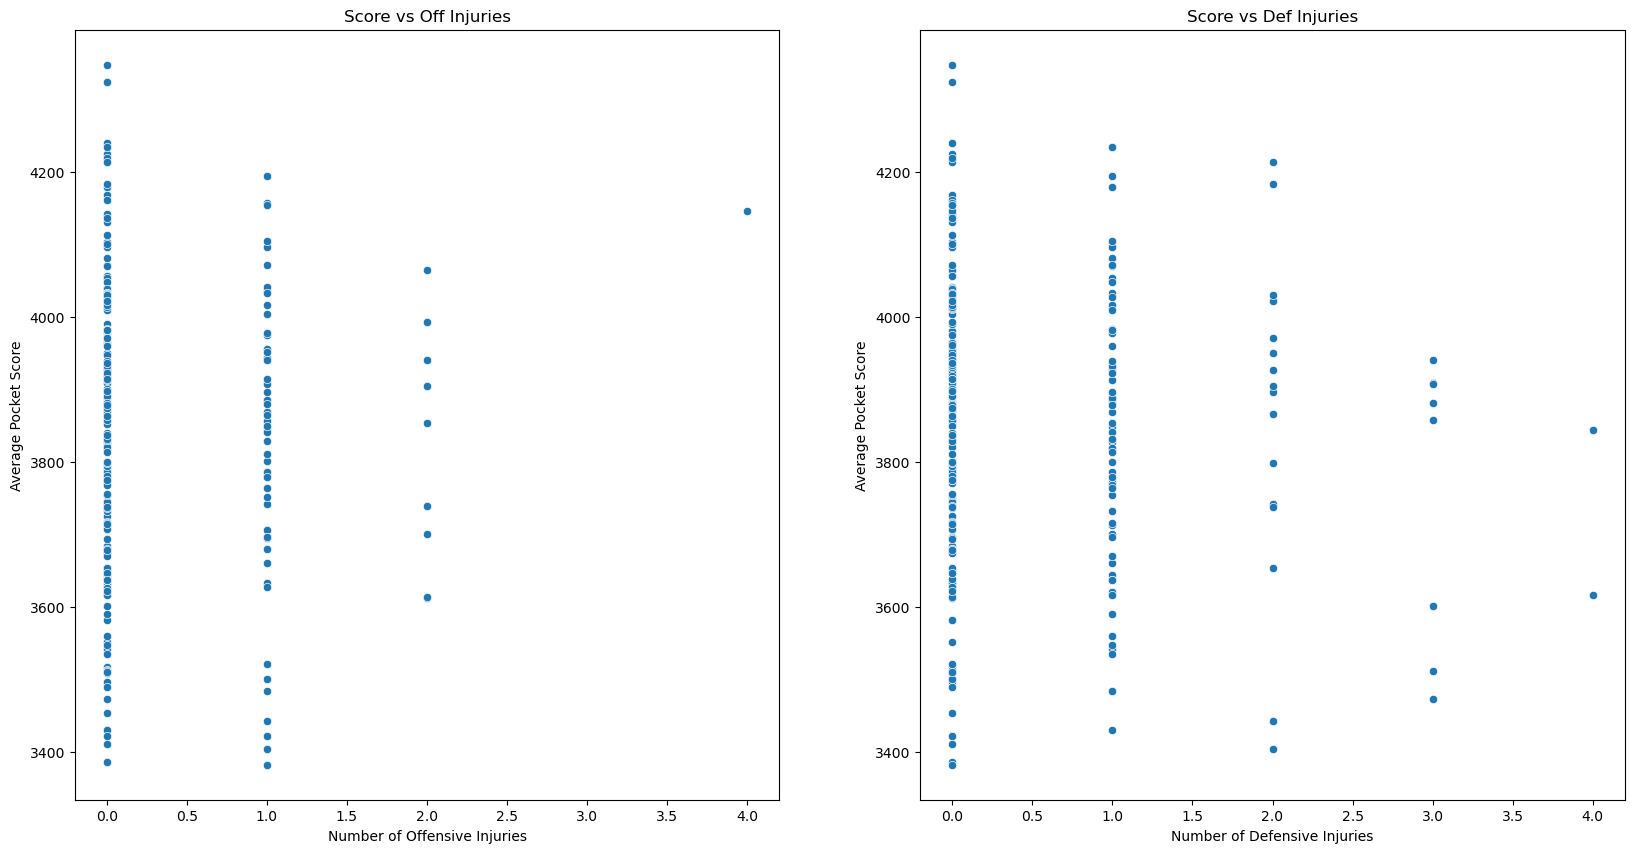

In [8]:
evaluate_match_scores(f"{preprocessing_path}/week_scores_and_features.csv")

## 3.3 - Full Season Analysis
In this analysis, a set of aggregations are performed to compare teams based on their entire season.

In [19]:
def process_team_perf_season(records, games_results):

    # Extract games result for this specific game
    game_result = games_results.loc[games_results.team == records.offTeam.unique()[0]]

    # Create a set of features for each match
    team_season_perf = {
        'offTeam': records.offTeam,
        'avgPocketScore': records.pocketScore.mean(),
        'cumScore': game_result.gameScore.sum(),
        'avgScore': game_result.gameScore.mean(),
        'gamesWon': game_result.hasWon.sum(),
        'cumGainedYards': records.gained_yards.sum(),
        'avgGainedYards': records.gained_yards.mean(),
        'numPassComplete': records.pass_complete.sum(),
        'percPassComplete': (records.pass_complete.sum() / len(records)) * 100.0,
        'numPocketHold': records.has_pocket_hold.sum(),
        'percPocketHold': (records.has_pocket_hold.sum() / len(records)) * 100.0,
        'numQBSacked': records.was_qb_sacked.sum(),
        'percQBSacked': (records.was_qb_sacked.sum() / len(records)) * 100.0,
        'numTouchdowns': records.touchdown.sum(),
        'numOffFouls': records.num_off_foul.sum(),
        'numDefFouls': records.num_def_foul.sum(),
        'numOffInjuries': records.num_off_injuries.sum(),
        'numDefInjuries': records.num_def_injuries.sum()
    }
    performance = pd.DataFrame(team_season_perf).drop_duplicates()
    return performance


def agg_scores_by_season(scores_file, game_features_file):
    
    # Load information based on the analysis provided
    analysis_results = pd.read_csv(scores_file)
    # Load the games information
    games_results = pd.read_csv(game_features_file)
    # Group all records by team and by match - This is not the right way of doing this
    season_performance_analysis = analysis_results.groupby(['offTeam']).apply(process_team_perf_season, games_results=games_results).reset_index(drop=True)
    # Return the analysis result  
    return season_performance_analysis

In [20]:
season_result = agg_scores_by_season(f"{preprocessing_path}/play_scores_and_features.csv", f"{preprocessing_path}/games_features.csv")
season_result.head(5)

,offTeam,avgPocketScore,cumScore,avgScore,gamesWon,cumGainedYards,avgGainedYards,numPassComplete,percPassComplete,numPocketHold,percPocketHold,numQBSacked,percQBSacked,numTouchdowns,numOffFouls,numDefFouls,numOffInjuries,numDefInjuries
0,ARI,3555.699720,246,30.750000,7,1853,7.885106,129,54.893617,201,85.531915,20,8.510638,13,5,14,2,4
1,ATL,4014.412508,148,21.142857,3,1815,6.280277,176,60.899654,272,94.117647,13,4.498270,15,7,20,2,4
2,BAL,3467.073257,187,26.714286,5,1935,7.140221,136,50.184502,220,81.180812,22,8.118081,12,4,4,3,5
3,BUF,3699.614009,229,32.714286,5,1762,6.937008,134,52.755906,227,89.370079,8,3.149606,16,11,14,0,3
4,CAR,3904.945920,165,20.625000,4,1745,5.935374,138,46.938776,255,86.734694,23,7.823129,7,9,15,2,2


In [21]:
season_result.to_csv(f"{preprocessing_path}/season_scores_and_features.csv", index=False)

In [24]:
def evaluate_season_scores(scores_file):

    # Load information based on the analysis provided
    analysis_results = pd.read_csv(scores_file)
    
    #################################################################
    # Run a set of analysis to explore the correlation between the score and the extracted features
    #################################################################
    # Play Outcome Analysis
    # Figure height and width
    width = 40
    height = 10
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 5
    # Analysis 1 - Score vs Cum Gained Yards
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='cumGainedYards')
    plt.xlabel("Cumulative Gained yards")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Cum Gained Yards")
    # Analysis 2 - Score vs Avg Gained Yards
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='avgGainedYards')
    plt.xlabel("Average Gained yards")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Avg Gained Yards")
    # Analysis 3 - Score vs Pass complete
    plt.subplot(rows,cols,3)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percPassComplete')
    plt.xlabel("Percentage Complete Passes")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs % Complete pass")
    # Analysis 4 - Score vs Pocket hold
    plt.subplot(rows,cols,4)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percPocketHold')
    plt.xlabel("Percentage Pocket hold")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs % Pocket hold")
    # Analysis 5 - Score vs Pocket hold
    plt.subplot(rows,cols,5)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='percQBSacked')
    plt.xlabel("Percentage QB Sacked")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs % QB Sacked")

    #################################################################
    # Game Analysis
    # Figure height and width
    width = 30
    height = 10
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 3
    # Analysis 1 - Avg Pocket Score vs Cum Score
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='cumScore')
    plt.xlabel("Cumulative Season Score")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Cum Score")
    # Analysis 2 - Avg Pocket Score vs Avg Score
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='avgScore')
    plt.xlabel("Average Season Score")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Avg Score")
    # Analysis 3 - Avg Pocket Score vs Games Won
    plt.subplot(rows,cols,3)
    sns.violinplot(data=analysis_results, y='avgPocketScore', x='gamesWon')
    plt.xlabel("Games Won")
    plt.ylabel("Average Pocket Score")
    plt.title("Avg Pocket Score vs Games Won")

    #################################################################
    # Foul analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Fouls
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numOffFouls')
    plt.xlabel("Number of Offensive Fouls")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Off Fouls")
    # Analysis 2 - Score vs Num Defensive Fouls
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numDefFouls')
    plt.xlabel("Number of Defensive Fouls")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Def Fouls")
    
    #################################################################
    # Injury analysis
    # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Injuries
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numOffInjuries')
    plt.xlabel("Number of Offensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Off Injuries")
    # Analysis 2 - Score vs Num Defensive Injuries
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numDefInjuries')
    plt.xlabel("Number of Defensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Def Injuries")

    #################################################################
    # Season Overall Performance
     # Figure height and width
    height = 10
    width = 20
    plt.figure(figsize=(width,height))
    # Number of subplots
    rows = 1
    cols = 2
    # Analysis 1 - Score vs Num Offensive Injuries
    plt.subplot(rows,cols,1)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numOffInjuries')
    plt.xlabel("Number of Offensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Off Injuries")
    # Analysis 2 - Score vs Num Defensive Injuries
    plt.subplot(rows,cols,2)
    sns.scatterplot(data=analysis_results, y='avgPocketScore', x='numDefInjuries')
    plt.xlabel("Number of Defensive Injuries")
    plt.ylabel("Average Pocket Score")
    plt.title("Score vs Def Injuries")  
    ##########################################################################

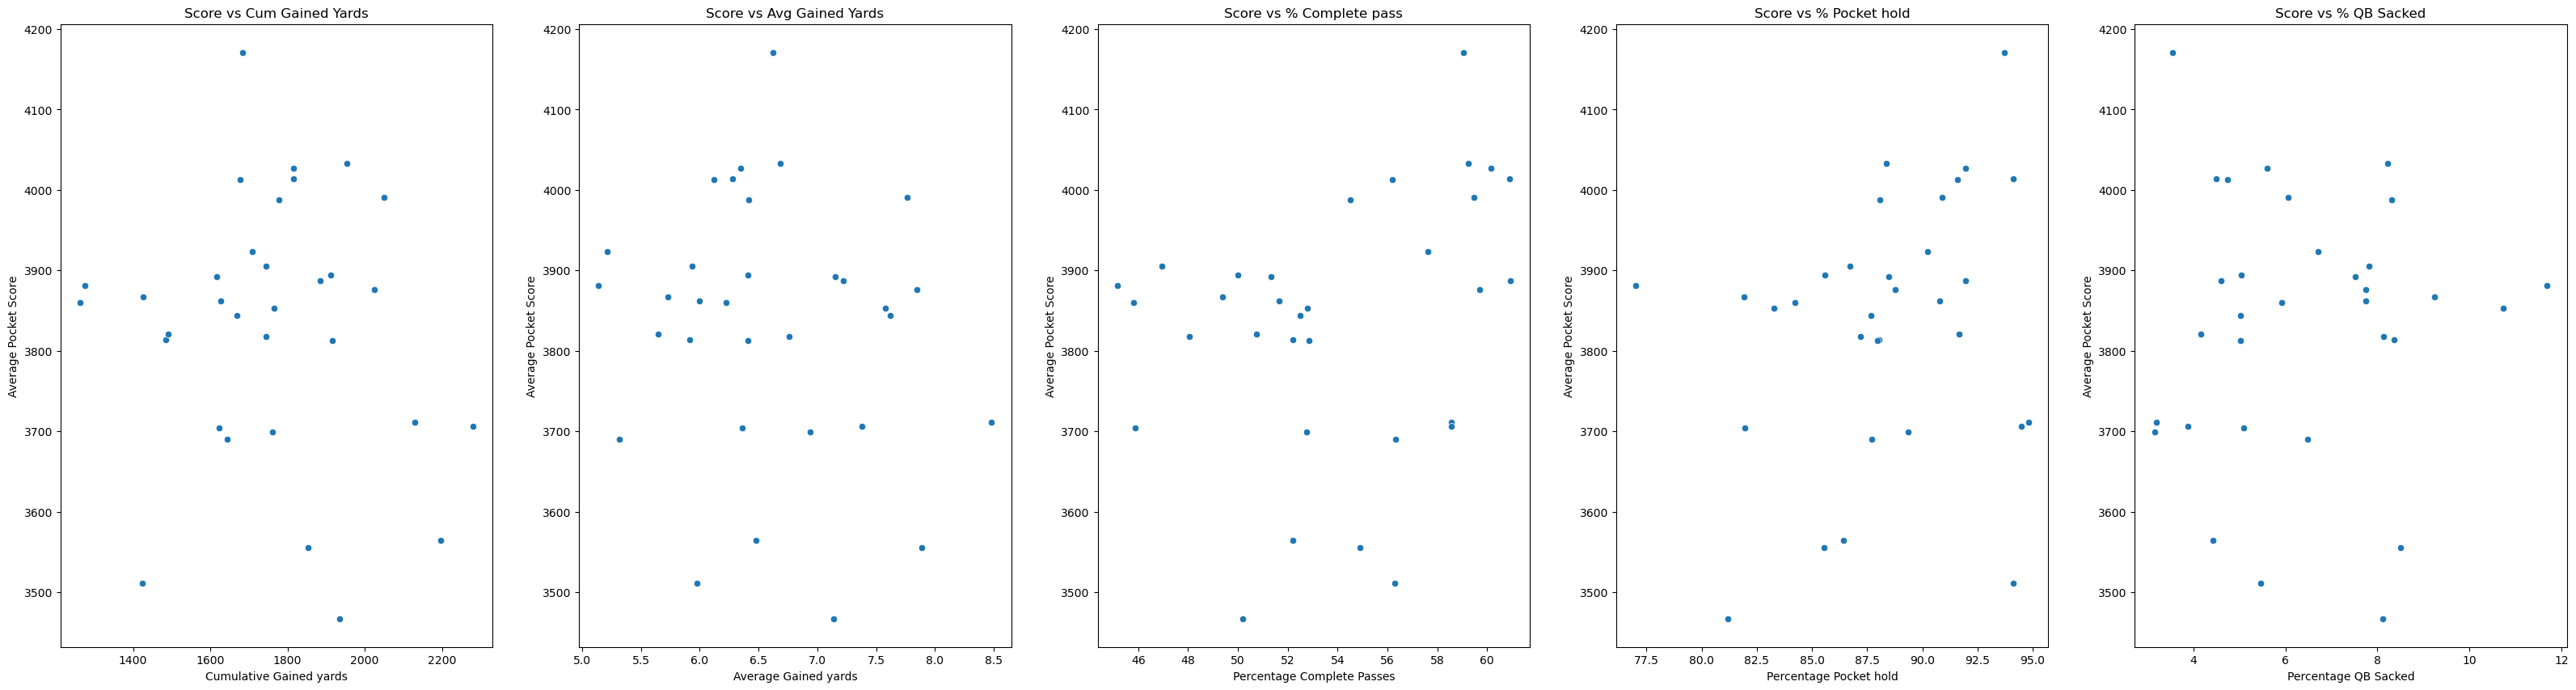

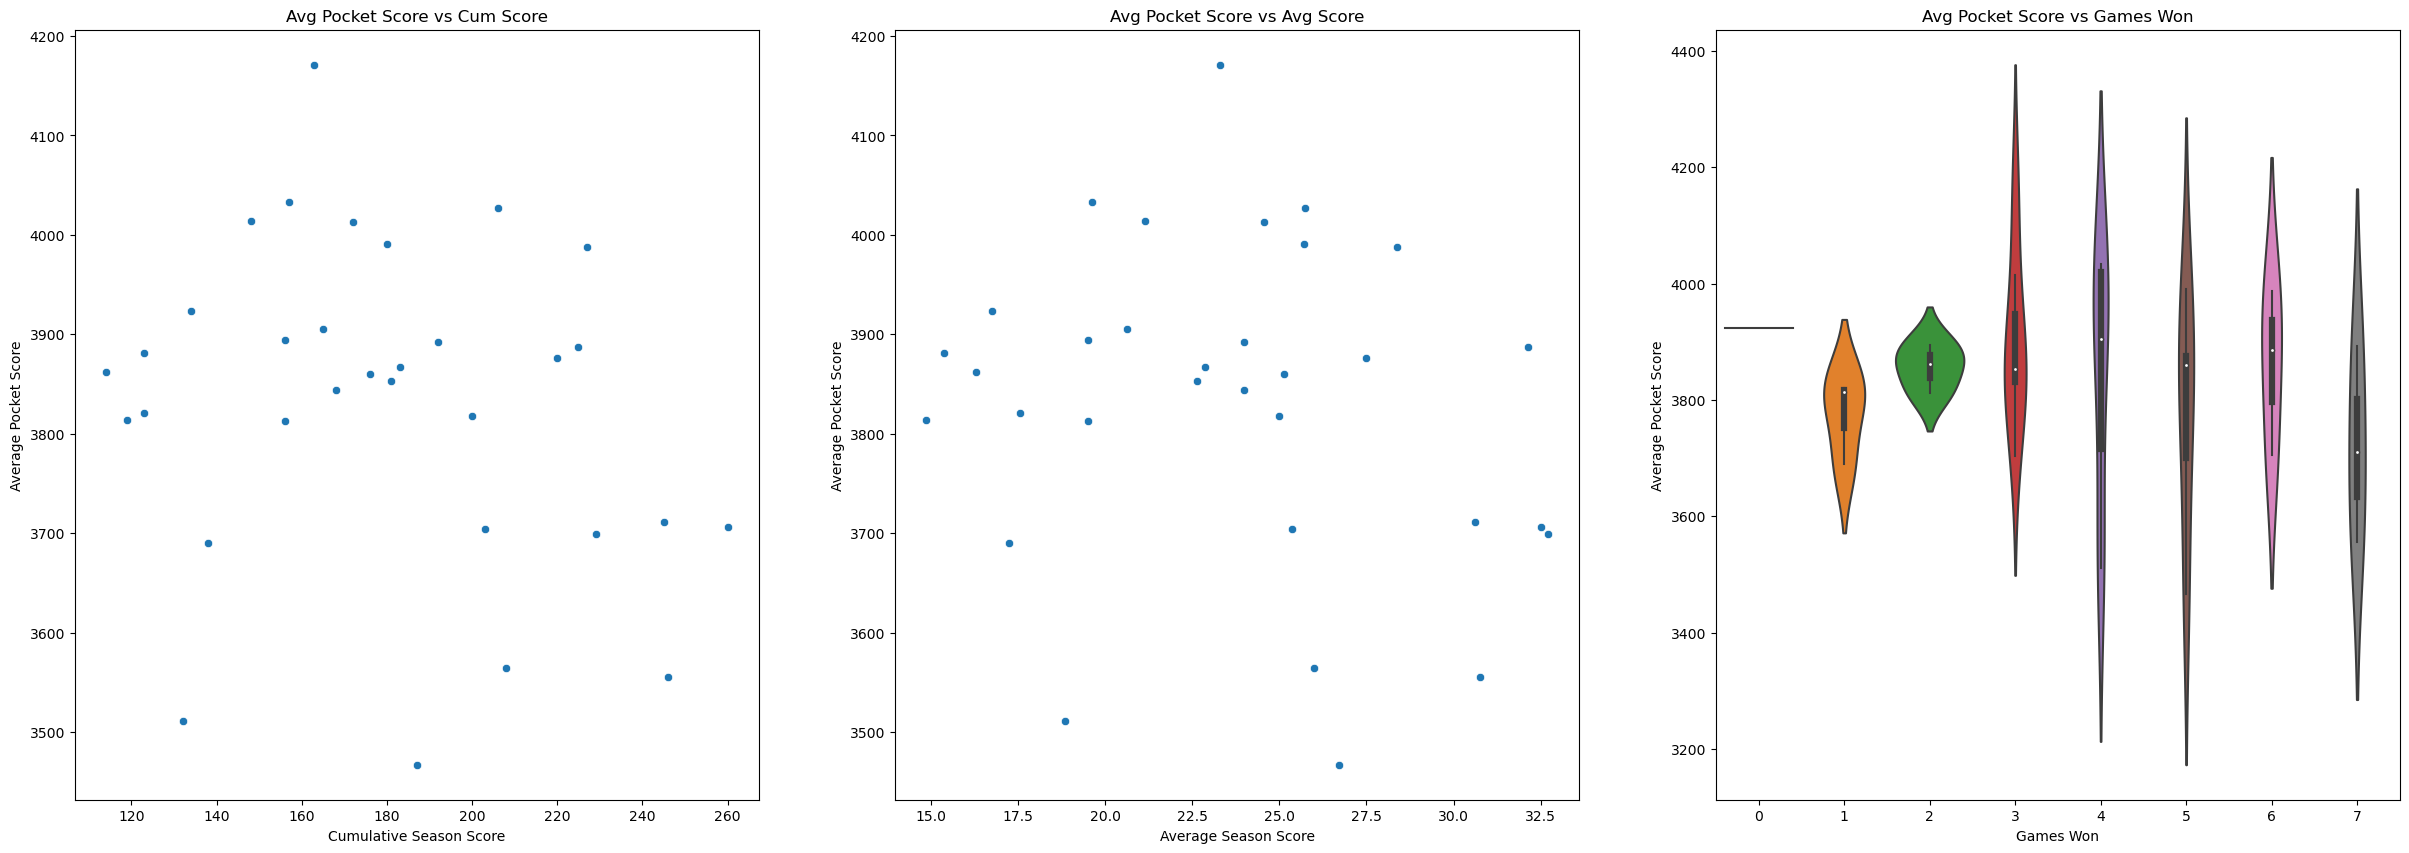

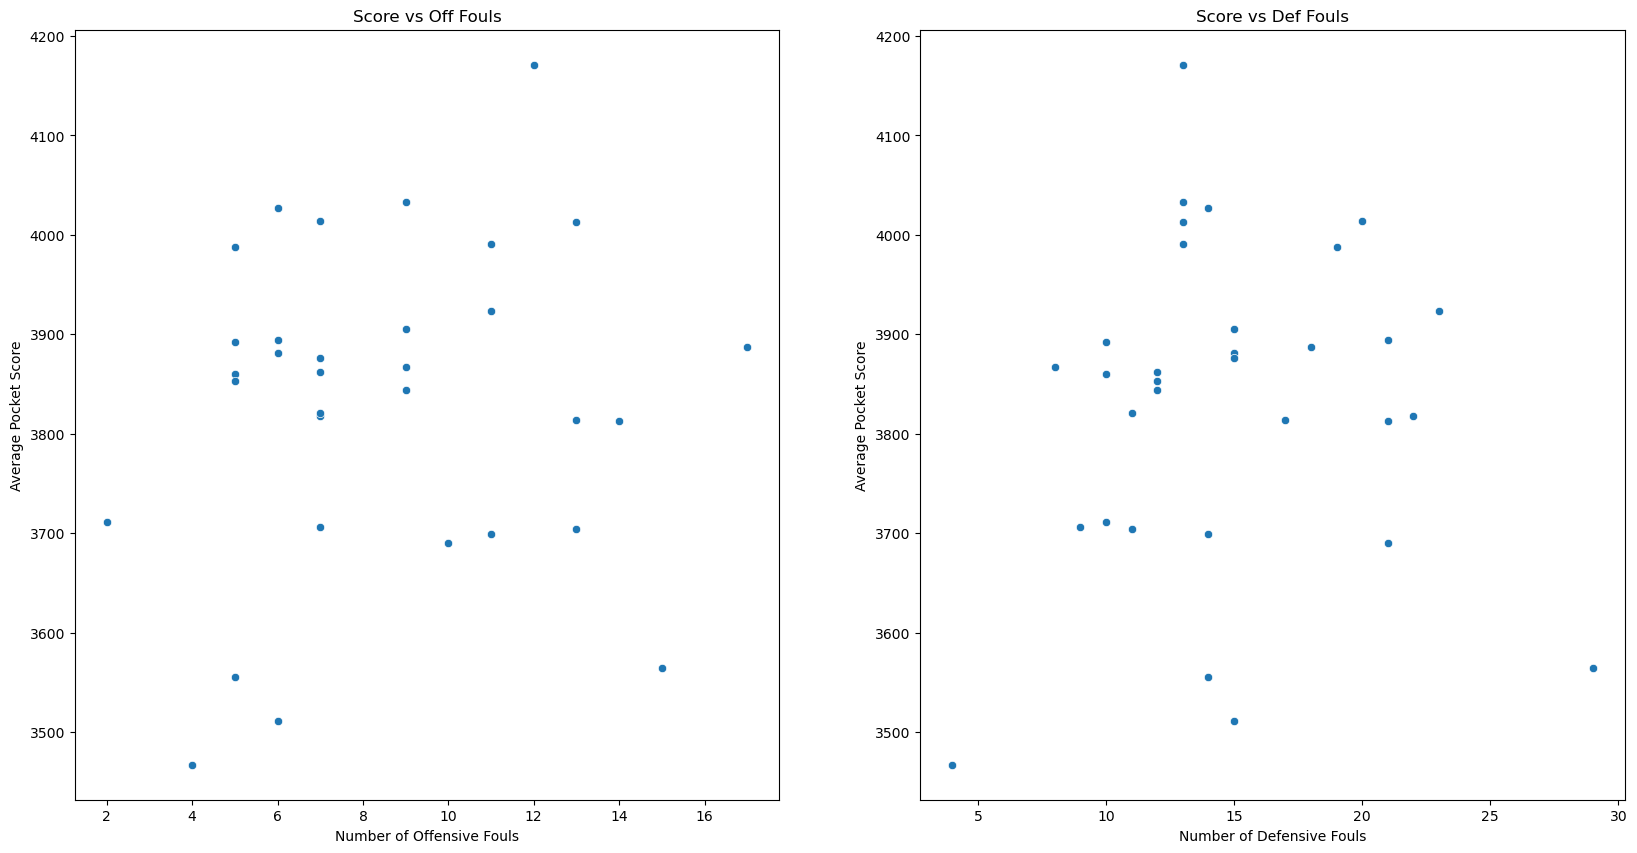

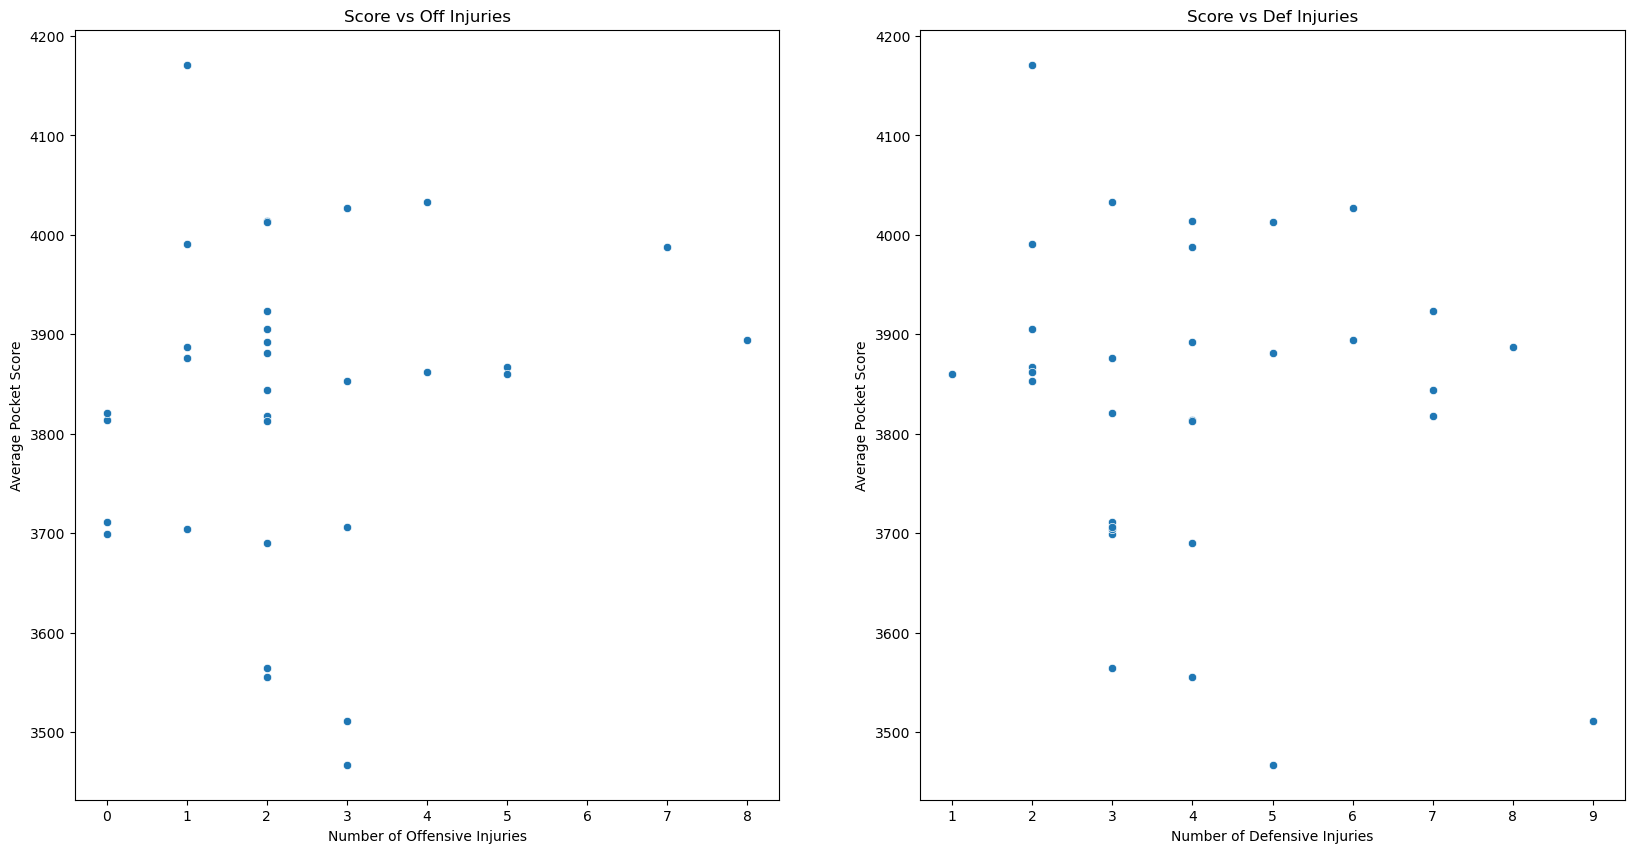

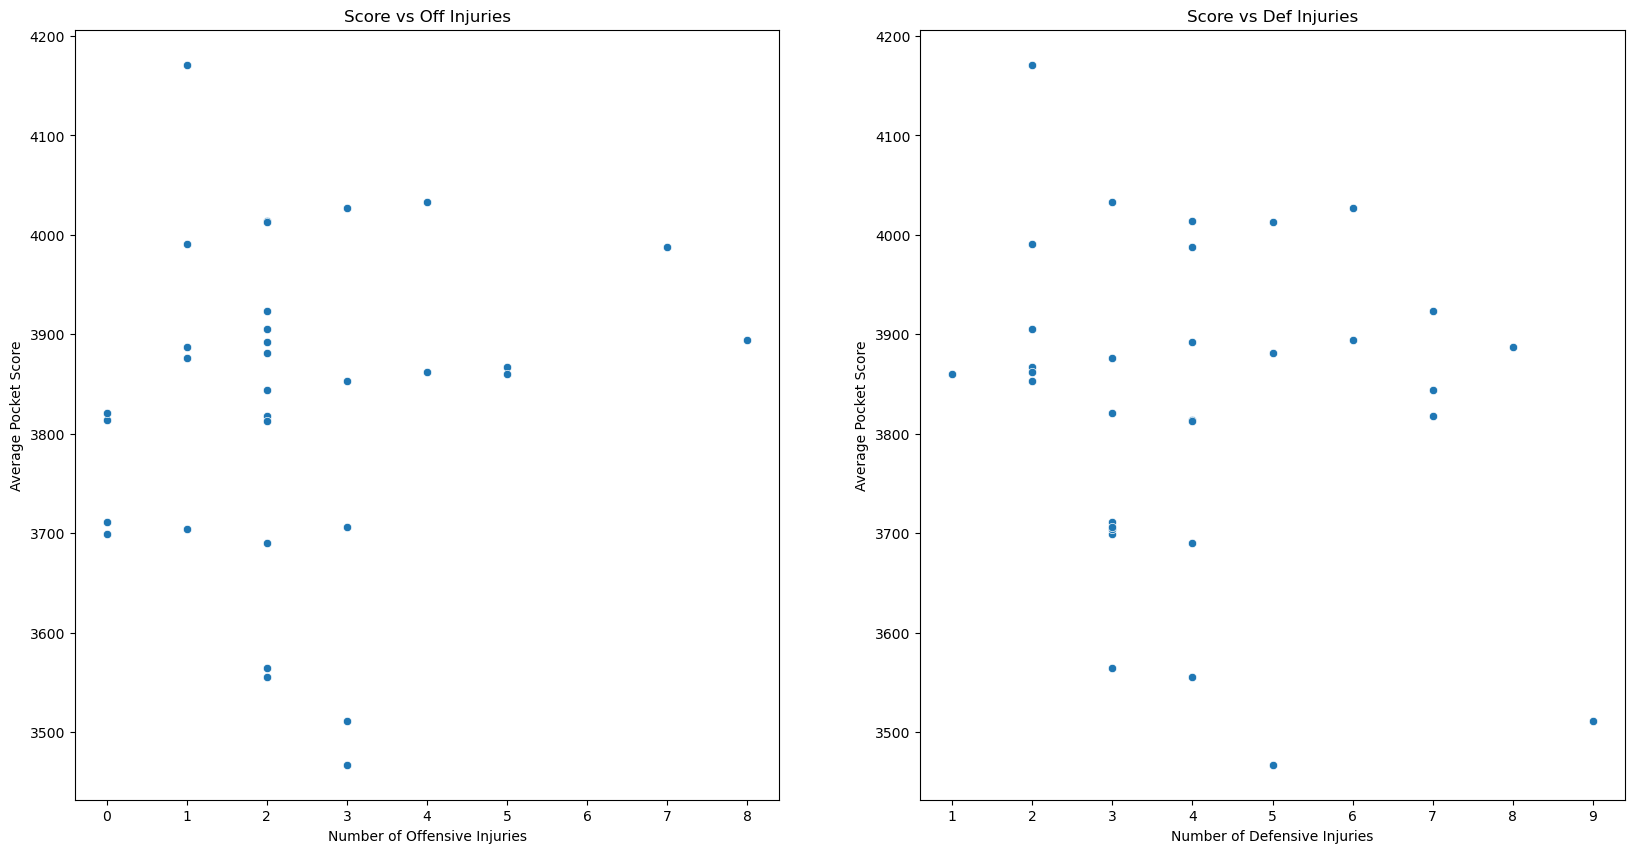

In [25]:
evaluate_season_scores(f"{preprocessing_path}/season_scores_and_features.csv")

# 4. Final Prototype Analysis

This section incorporates all steps created so far, into two main functions:
- **visualize_play** - Visualize the play using Full Field, Pocket and Score Array
- **run_full_pipeline** - Run the pipeline E2E, putting together all the steps to load, process, analyse and visualize the plays. 

In [38]:
def visualize_play(week_data, gameId, playId, config):

    # Full Pitch Evaluation
    # Extract info from the play
    team1, team2, ball = extractPlay(week_data, gameId, playId)

    # Plot the play in Full Field
    fig_field = animatePlay_Generic(team1, team2, ball, drawPitch(), store_path=f"../videos/{gameId}_{playId}_fullPitch.mp4")
    display.display(fig_field)
    plt.close()

    # Preprocess the play
    team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'], post_snap_time=config['post_snap_time'])

    # Plot the play in the Pocket
    fig_field = animatePlay_Generic(team1, team2, ball, drawPocket(), store_path=f"../videos/{gameId}_{playId}_pocket.mp4")
    display.display(fig_field)
    plt.close()

    # Analyze the position of the defensive players
    # Calculate players influence
    scores = extract_play_players_influence(
        team_def=team2,
        infl_funct=config['player_infl_funct'],
        config=config
    )

    # Plot the play
    fig_scores = animateScores(scores, store_path=f"../videos/{gameId}_{playId}_scores.mp4")
    display.display(fig_scores)
    plt.close()

    #########################################################################
    # This function can be enhanced with plotting of the score with time    #
    #########################################################################



In [39]:
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))
week1_data.head(5)

# Define Game & Play ID
gameId = "2021090900"
playId = "97"

# Visualize play
visualize_play(week1_data, gameId, playId, config)

In [40]:
def run_full_pipeline(input_path, output_path, config):

    features_file = f"{output_path}/play_features.csv"
    scores_and_features_file = f"{output_path}/play_scores_and_features.csv"
    match_scores_file = f"{output_path}/match_scores_and_features.csv"
    season_scores_file = f"{output_path}/season_scores_and_features.csv"

    ##########################################
    # STEP 1 - CREATE FEATURE VECTOR         #
    ########################################## 
    # Load information regarding plays
    plays_data = pd.read_csv(os.path.join(input_path, 'plays.csv'))

    # Perform all feature extractions
    plays_outcomes = extract_play_outcome_features(plays_data).set_index(['gameId', 'playId'])
    plays_formation = extract_formation_features(plays_data).set_index(['gameId', 'playId'])
    plays_fouls = extract_foul_features(plays_data).set_index(['gameId', 'playId'])
    plays_injury = extract_injury_features(plays_data).set_index(['gameId', 'playId'])

    # Merge all these tables into one single big table
    play_features = pd.concat([plays_outcomes, plays_formation, plays_fouls, plays_injury], axis=1)
    play_features.to_csv(features_file)

    ##########################################
    # STEP 2 - PREPROCESS ALL PLAYS          #
    ########################################## 
    # Define number of weeks to analyize
    num_weeks = 8

    # Generate files names
    week_files = []
    for i in range(num_weeks):
        week_files.append(f'week{i+1}.csv')

    # For all weeks, extract scores
    all_scores_info = []
    for week_file in week_files:

        print(f"- Analyzing {week_file}")

        # Load information for an entire week
        week_data = pd.read_csv(os.path.join(input_path, week_file))

        # Extract information about the associated games and plays
        unique_ids = week_data[['gameId', 'playId']].drop_duplicates().values

        for gameId, playId in tqdm.tqdm(unique_ids):

            # Extract info from the play
            team1, team2, ball = extractPlay(week_data, gameId, playId)
            team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'])

            ############################################################
            # Extract player influence
            players_influence = extract_play_players_influence(team2, infl_funct=config['player_infl_funct'], config=config)

            # Extract field price
            field_price = calculate_field_price(price_funct=config['field_price_funct'], config=config)

            # Calculate scores
            pocketScore = calculate_score(players_influence, field_price)
            ############################################################
            # For now, we will include random values
            # pocketScore = random.uniform(0, 1)
            ############################################################

            all_scores_info.append({
                'gameId': gameId,
                'playId': playId,
                'offTeam': team1.team.drop_duplicates().values[0],
                'pocketScore': pocketScore 
            })

    # Merge scores with play features
    scores = pd.DataFrame(all_scores_info).set_index(['gameId', 'playId'])
    play_scores_and_features =  pd.concat([scores, plays_outcomes, plays_formation, plays_fouls, plays_injury], axis=1)
    play_scores_and_features.to_csv(scores_and_features_file)

    ##########################################
    # STEP 3 - ANALYZE THE RESULTS           #
    ########################################## 
    # Perform analysis by Single Play
    evaluate_singleplay_scores(scores_and_features_file)

    # Aggregate by match
    result = agg_scores_by_match(scores_and_features_file)
    result.to_csv(match_scores_file)

    # Perform analysis by Match
    evaluate_match_scores(match_scores_file)

    # Aggregate by season
    season_result = agg_scores_by_season(scores_and_features_file)
    season_result.to_csv(season_scores_file)

    # Perform analysis by Match
    evaluate_season_scores(season_scores_file)


In [ ]:
# Input parameters
# Define input parameters
input_path = '../input'
output_path = '../processing'

config = {
    'hold_QB_ref': 20,
    'post_snap_time': 8,
    'pocket_len': 30.0,
    'pocket_res': 0.1,
    'pocket_linear_max_value': 1.0,
    'pocket_gaus_mu': 0.0,
    'pocket_gaus_sigma': 5.0,
    'gaus_mu': 0.0,
    'gaus_sigma': 2.0,
    'field_price_funct': gaussian_field_price,
    'player_infl_funct': gaussian_player_influence_score
}

run_full_pipeline(input_path, output_path, config)